# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.





# 1- Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, I will use the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [5]:
#to ignore warnings and have the plot
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


#to fetch data from sqlite file
import sqlite3
#for preprocessing use the pandas dataframe
import pandas as pd
#numpy to feed to the algorithms
import numpy as np
#nltk for language related tasks
import nltk
#don't know why id imported this
import string
#for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn for feature transformer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics

#another metric to measure the performance of the model
from sklearn.metrics import roc_curve, auc
#stemming technique
from nltk.stem.porter import PorterStemmer


# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#word2 vec models
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#to store and save the model
import pickle

#tqdm is to get the nice progress bar on loops
from tqdm import tqdm
import os



Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


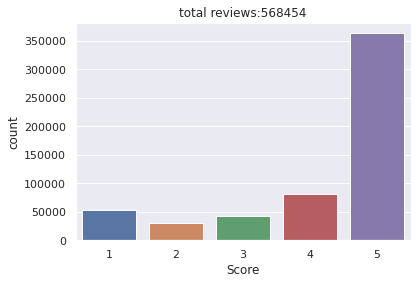

In [6]:
# using the SQLite Table to read data.

con = sqlite3.connect('database.sqlite')  #this contains the database file for the food reviews 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

#for all reviews

#plot for all the points based on the review

#query to fetch all the data 
all_review = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

#plotting the reviews based on the original distribution
import seaborn as sns
sns.set(style="darkgrid")
#make count plots of all the data 
ax = sns.countplot(x="Score", data=all_review)
ax.set_title('total reviews:'+str(all_review.shape[0]))

#filtering only the data with positive and negative reviews just remove the 3 star rating reviews because the really
#dont help 

filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 
""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be negative and vice-versa
actualScore = filtered_data['Score']

positiveNegative = actualScore.map(partition) 

#now score become 1 or 0 ==> (1 for 4 or 5 stars || and 0 for 1 or 2 stars)
filtered_data['Score'] = positiveNegative #replace this as the actual column

print("Number of data points in our data", filtered_data.shape)

filtered_data.head(3)


# # 2- preprocessing to clean the data 

# ## Select the duplicate rows and remove them if they occur in the data 

# 2- preprocessing to clean the data 

## Select the duplicate rows and remove them if they occur in the data 

In [7]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [8]:
print(display.shape)
display.head(10) #show only 10 valid rows

#this means in the total data 80668 rows are duplicates

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2
5,#oc-R12MGTQS5KZZRV,B005HG9ESG,"SKY2110 ""SKY2110""",1344211200,5,This is the highest PH level I can find withou...,3
6,#oc-R13EBF129DBX88,B005ZBZLT4,mary,1344729600,2,This coffee is not what I expected. I thought...,2
7,#oc-R13NNUL4EKL4FL,B005HG9ESG,N. Chernyavskaya,1348358400,1,I tested the pH of this water. I am very disap...,3
8,#oc-R14ZSRYW2YB41B,B005HG9ESG,A. Crafton,1346284800,5,I drank this on ice after a workout. It was ve...,3
9,#oc-R15343ZW0UTLMR,B007TGDXNO,"Lisa L. Nolen ""SimplyLisaLisa""",1346457600,1,"I shouldn't label myself a coffee connoisseur,...",2


In [9]:
#this is just to show that how many times the row has occured

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="#oc-R11D9D7SHXIJB9"
ORDER BY ProductID
""", con)
display.head()

#as we can see that the data shows that there are three occurances of the same user with exactly same review

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
1,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
2,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


In [10]:
#Sorting data according to ProductId in ascending order
#sort the table with the product id column 
#axis 0 means that we want to sort row wise on the column selected
#sorting algorithm is quick sort
#we want to sort ascendingly
#we can also place NANs in the end to make sure that we have ended
#inplace basically means we don't wanna override the actual data 

sorted_data=filtered_data.sort_values('ProductId', 
                                      axis=0, 
                                      ascending=True, 
                                      inplace=False, 
                                      kind='quicksort',
                                      na_position='last')

In [11]:
sorted_data.tail(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
176791,191721,B009UOFTUI,AJVB004EB0MVK,D. Christofferson,0,0,0,1345852800,weak coffee not good for a premium product and...,"This coffee supposedly is premium, it tastes w..."
1362,1478,B009UOFU20,AJVB004EB0MVK,D. Christofferson,0,0,0,1345852800,weak coffee not good for a premium product and...,"This coffee supposedly is premium, it tastes w..."
303285,328482,B009UUS05I,ARL20DSHGVM1Y,Jamie,0,0,1,1331856000,Perfect,The basket was the perfect sympathy gift when ...
5259,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...
302474,327601,B009WVB40S,A3ME78KVX31T21,K'la,0,0,1,1351123200,Tasty!,I purchased this to send to my son who's away ...


In [12]:
#sorting makes removal of duplicates slightly faster
#we want to remove the places that have the same "UserId","ProfileName","Time","Text"
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
#as we can now see we are down with 364k reviews from 525K reviews

(364173, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [14]:
#we can also remove the rows that have helpfullness numerator greater than denominator
final=final[final["HelpfulnessNumerator"] <= final["HelpfulnessDenominator"]]
final.shape

#only two of the mislabelled reviews are removed

(364171, 10)

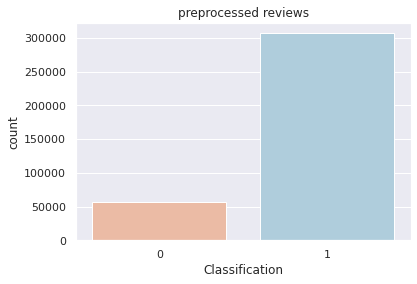

In [15]:
#How many positive and negative reviews are present in our dataset?
final["Score"].value_counts() #gives the value counts of the positive and negative review seperation

#plotting the downsampled reviews to only positive and negative
sns.set(style="darkgrid")
#make count plots of all the data 
sns.countplot(x='Score', data=final, palette='RdBu')
plt.xlabel('Classification')
plt.title("preprocessed reviews")
plt.show()


# #let's see what the table looks like
# 
# 
# y_tr=final["Score"].values
# row=y_tr.shape[0]
# y_tr=y_tr.reshape(row,1)
# print(y_tr.shape)
# joblib.dump(y_tr,"y_labels_enw2v_e2v.pkl")
# 
# #use this to save the y_labels
# #y_labels=final["Score"]

#let's see what the table looks like


y_tr=final["Score"].values
row=y_tr.shape[0]
y_tr=y_tr.reshape(row,1)
print(y_tr.shape)
joblib.dump(y_tr,"y_labels_enw2v_e2v.pkl")

#use this to save the y_labels
#y_labels=final["Score"]

In [16]:
new = final[['Score','Text']]
new.to_csv("afr_modiefied.csv")

In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not' #because these are cruicial bit of information
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


In [19]:
# Combining all the above stundents
import re

from bs4 import BeautifulSoup

def decontracted(phrase):
    """substitute stop words"""
    
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

##################emoji based preprocessing
import emoji
#load e2v file
e2v = KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)
#print the vocab of the file
e2v_words= list(e2v.wv.vocab)
#make a demojified vocab
demojized_e2v_words=[]
for word in e2v_words:
    new=emoji.demojize(word)
    demojized_e2v_words.append(new)


def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False

def extract_emojis(str):
    # https://stackoverflow.com/questions/43146528/how-to-extract-all-the-emojis-from-text
    return ' '.join(c for c in str if c in emoji.UNICODE_EMOJI) 

def emoji_convert(word):
    """emoji's are represented as->> :emoji_text: 
    we need to count the occurance of how many such patterns exist
    word>> -,👍 o/p - should be ":thumbsup:"
    word>> :👍  o/p - should be ":thumbsup:"
    word>> 👍®  o/p - should be ":thumbsup: :registered:
    basically extracts the emoji's only from the text
    """
    new_string_with_emoji= extract_emojis(word) #get's all the emoji's
    demojified=emoji.demojize(new_string_with_emoji)
    return demojified
    


#print(emoji.demojize("wtf is wrong with you 😂 ? 👍❤️😊"))



###############################################################

from tqdm import tqdm

preprocessed_reviews = []
# tqdm is for printing the status bar

emoji_ind=[] #denotes which sentence contains the emoji

i=0
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance) #remove html links
    sentance = BeautifulSoup(sentance, 'lxml').get_text() #remove html tags
    sentance = decontracted(sentance) #remove abbreviations
    sentance = re.sub("\S*\d\S*", "", sentance).strip() # remove words with numbers
    
    emoji_sent= text_has_emoji(sentance) #does emoji exist in sentence
    if(emoji_sent): #this checks if the review has emoji
        #if we are here this means we have emoji
        emojis_list=emoji_convert(sentance).split(" ") #gets all the emoji's in the sentence 
        #print(emojis_list) #this list contains all the emoji's in the sentence 
        emoji_ind.append(i) #store the emoji index number to keep track of it
        #now the emoji can be used as a individual word or mixed with a word or combination of multiple emojis
        demo=""#convert back to emoji 
        #apply special character transformation to only non emoji words as this will remove emoji's
        for word in sentance.split(): #for every word in the sentance 
            if word in e2v_words: #either the word itself is a direct emoji or a combination of characters and emoji #this means a direct emoji
                word=emoji.demojize(word)
            elif(text_has_emoji(word)): #the word is made up of emoji character
                word=emoji_convert(word)
            demo+=word+" "
        sentance=demo
        
    if not(emoji_sent): #if there is no emoji in the sentance
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)#then apply sentance substitute for normal regex
   

    sentance=sentance.strip()
    sentance=emoji.emojize(sentance)
    
    #sentance = re.sub('[^A-Za-z]+', ' ', sentance) # remove the special characters from the words using reg ex
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords) #join with spaces after removing stop words
    #sentance=emoji.emojize(sentance) #convert them back into their emoji form
    preprocessed_reviews.append(sentance.strip())
    i+=1

print(emoji_ind) #these sentences basically contain all the emoji's

    

100%|██████████| 364171/364171 [02:35<00:00, 2347.36it/s]

[1702, 8579, 8856, 9205, 13933, 15217, 18205, 19246, 19771, 19834, 20401, 23410, 24568, 26999, 27005, 27196, 32741, 38312, 38633, 40161, 45231, 53281, 69179, 71165, 73511, 73678, 74842, 75101, 79366, 86361, 86382, 86902, 94285, 97262, 98507, 98819, 99252, 100222, 100384, 106748, 111910, 112150, 112403, 112417, 116178, 117277, 122575, 122647, 127872, 136133, 136154, 138404, 139398, 141431, 142170, 142306, 145982, 151336, 153390, 155210, 155213, 155225, 155226, 155227, 155228, 155229, 155235, 155256, 155259, 155260, 155261, 155264, 155265, 155266, 155267, 155268, 155269, 155270, 155281, 155283, 155290, 155293, 155295, 155302, 155303, 155305, 155306, 155308, 155361, 155362, 155363, 155364, 155365, 155366, 155368, 155369, 155370, 155394, 157714, 157850, 158059, 164582, 171205, 171613, 175549, 179393, 181833, 184999, 194078, 196377, 198278, 199479, 202393, 202933, 203111, 204311, 206605, 209703, 212994, 216651, 218359, 222230, 222300, 223631, 223650, 229409, 229627, 236459, 237066, 239164, 

In [20]:
#print all the emoji present rows
for element in emoji_ind:
    print("\n=========my preprocessed review========")
    print(preprocessed_reviews[element]) #get all the reviews
    print("\n=========this is the original review========")
    print(final["Text"].values[element])
    print(final["Score"].values[element])


=========my preprocessed review========
march med received notification today ® llc., parent company ® pet foods, specific lots ® canned cat foods, purchased store, returned us immediately replacement.the company reassured us no immediate threat health customer beloved pets, however, recent testing indicated specific lots might contain less adequate levels thiamine (also known vitamin fed products time could risk developing thiamine deficiency. although risk thiamine deficiency remote, company taking extra precaution voluntarily removing products store shelves asking customers return affected lots. company also taken additional steps manufacturing process ensure not happen again.-------------------------------------------------------------------------------i feeding wellness years. ten year old optimal health. never surgery spay, antibiotics couple times. fed wellness since received her.

=========this is the original review========
March 1, 2011<br /><br />Vet Med received notificati

10000it [00:00, 626970.01it/s]


There are 2205021 words in the combination of all pos review.
There are 459048 words in the combination of all neg review.


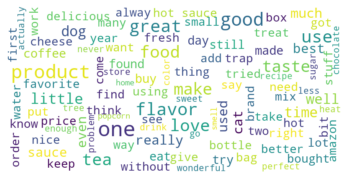

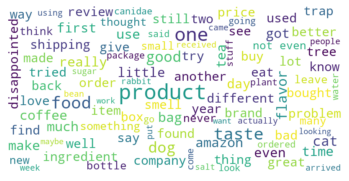

this is the len of the text : 92782645


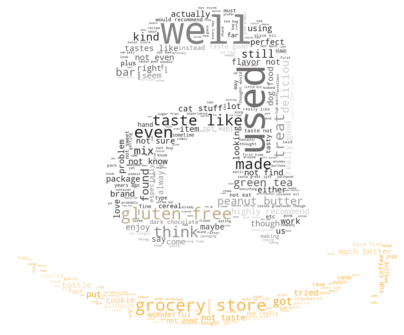

In [21]:
#generate positive and negative words word cloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

pos_text=""
neg_text=""

i=0
for review,score in tqdm(zip(preprocessed_reviews,final["Score"])):
    if(score==1):
        pos_text += review
    else:
        neg_text += review
    i+=1
    if(i>10000):
        break
        
print ("There are {} words in the combination of all pos review.".format(len(pos_text)))
print ("There are {} words in the combination of all neg review.".format(len(neg_text)))


#positive word cloud 
wordcloud = WordCloud(width=800, height=400,max_font_size=50, max_words=100, background_color="white").generate(pos_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#negative word cloud
wordcloud = WordCloud(width=800, height=400,max_font_size=50, max_words=100, background_color="white").generate(neg_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Start with one review:

text=""

for review in preprocessed_reviews:
    text+=review
    
print("this is the len of the text : {}".format(len(text)))
    
#load the masking image  for amazon image 




#amazon word cloud for all the reviews in the image 
from wordcloud import ImageColorGenerator

# Generate a word cloud image
mask = np.array(Image.open("amazon_mask.png"))
wordcloud_usa = WordCloud( background_color="white", mode="RGBA", max_words=300, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_usa.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("masked_amazon.png", format="png")

plt.show()




307061 57110


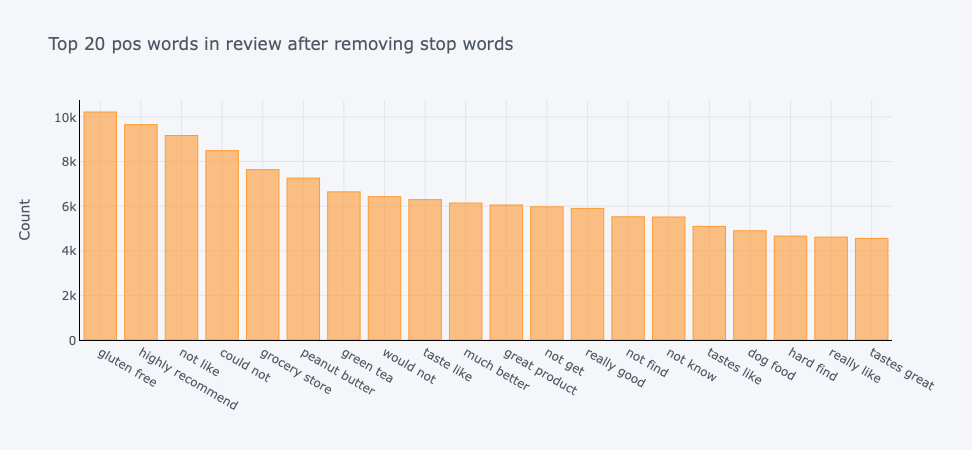

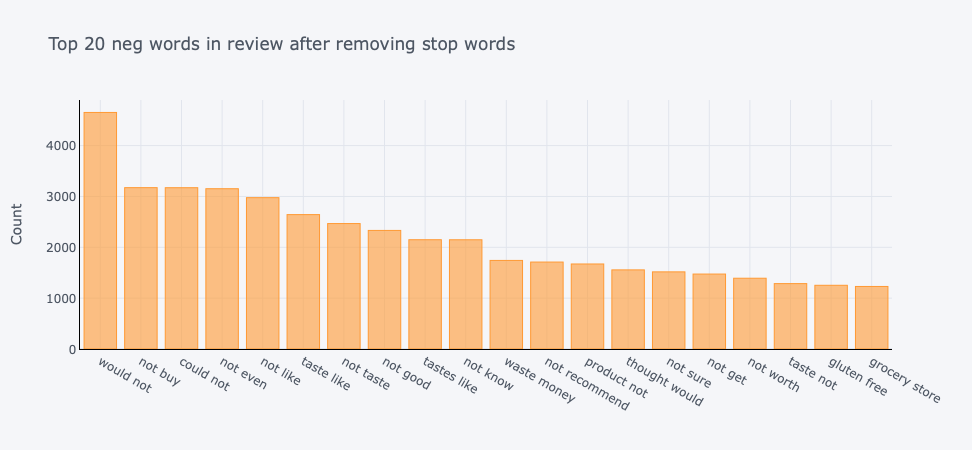

In [22]:
#bigrams representations of common words in both the segments

#top 20 bigrams in the data after preprocessing
#we use the bigrams because unigram will have alot of common words in both the categories

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

pos_review=[]
neg_review=[]
for review,score in zip(preprocessed_reviews,final["Score"]):
    if (score==1):
        pos_review.append(review)
    else:
        neg_review.append(review)

#seperates the pos review and neg reviews into 2 different lists
print(len(pos_review),len(neg_review))


common_words_pos = get_top_n_words(pos_review, 20)
common_words_neg = get_top_n_words(neg_review, 20)

#print pos review count
#print("this is the positive side")
#for word, freq in common_words_pos:
    #print(word, freq)

#print neg review count
#print("this is the negative side")
#for word, freq in common_words_neg:
    #print(word, freq)
    

df_pos = pd.DataFrame(common_words_pos, columns = ['ReviewText' , 'count'])
df_pos.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 pos words in review after removing stop words')

df_neg = pd.DataFrame(common_words_neg, columns = ['ReviewText' , 'count'])
df_neg.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 neg words in review after removing stop words')



[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


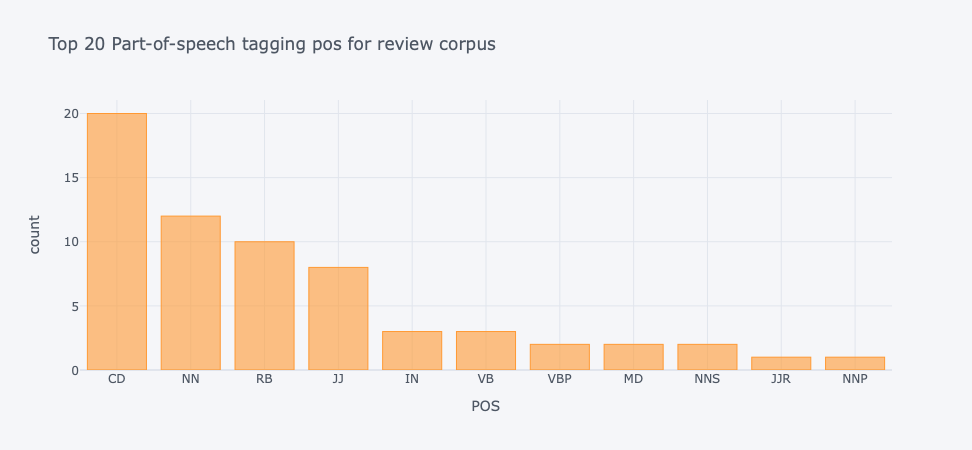

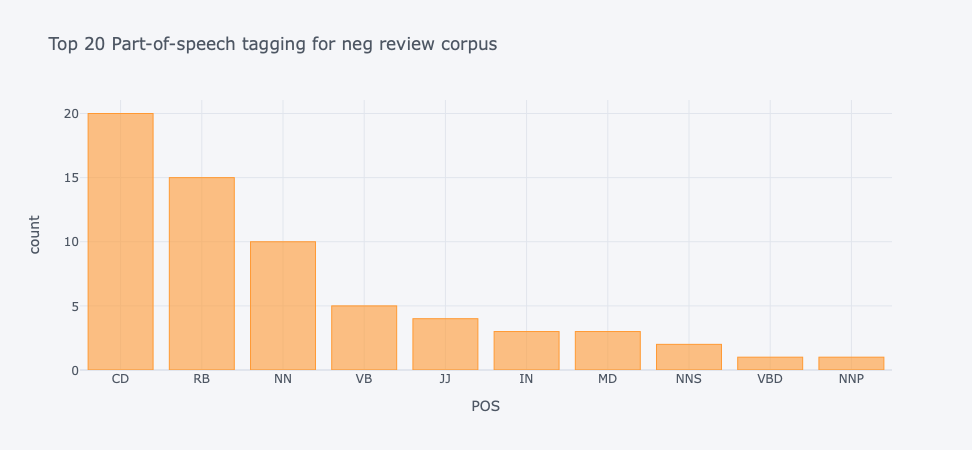

In [23]:
#pos tagging for each of the reviews using 
#the textblob library

#for positive reviews
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from textblob import TextBlob
blob = TextBlob(str(df_pos['ReviewText']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging pos for review corpus')

#for negtive reviews
blob = TextBlob(str(df_neg['ReviewText']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging for neg review corpus')

In [24]:
# a list of all pos tags for reference
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://www.researchgate.net/profile/Vivek_Singh53/publication/221225906/figure/tbl1/AS:652572981473300@1532596931702/Penn-Treebank-Parts-of-Speech-Tags-excluding-punctuations.png")

# feature transformation

#  training a w2vec or loading from the file

In [25]:
i=0
list_of_sentance=[]

for sentance in tqdm(preprocessed_reviews):
    list_of_sentance.append(sentance.split())
    
print(list_of_sentance[911])
    
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=True
want_to_use_google_w2v = True
want_to_train_w2v = False

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=300, workers=-1)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    print("saving the model to disk")
    w2v_model.wv.save_word2vec_format('my_model.bin')
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        e2v = KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

100%|██████████| 364171/364171 [00:03<00:00, 119820.57it/s]


['great', 'tea', 'flavor', 'good', 'works', 'well', 'priced', 'right', 'fast', 'shipping', 'like', 'herbal', 'teas', 'try', 'like']
[('terrific', 0.7989331483840942), ('fantastic', 0.7935211658477783), ('tremendous', 0.7748856544494629), ('wonderful', 0.7647868394851685), ('good', 0.7291510105133057), ('incredible', 0.7032873630523682), ('marvelous', 0.6971102952957153), ('phenomenal', 0.6841565370559692), ('amazing', 0.6634128093719482), ('awesome', 0.6510506868362427)]
[('Worst', 0.6146092414855957), ('weakest', 0.6143776774406433), ('scariest', 0.5957258343696594), ('ugliest', 0.5931180715560913), ('best', 0.5835110545158386), ('bleakest', 0.5718506574630737), ('strongest', 0.567145586013794), ('nastiest', 0.5644308924674988), ('lousiest', 0.5631451606750488), ('toughest', 0.5624395608901978)]


In [26]:
# a comparison of our w2vec and google's word 2 vec
my_model=KeyedVectors.load_word2vec_format('my_model.bin')
try:
    print("google's w2vec")
    print(w2v_model.wv.most_similar('great'))
    print(w2v_model.wv.most_similar('worst'))
    print(w2v_model.wv.most_similar('♥'))
    print(w2v_model.wv.most_similar('®'))
    print("printed all the vector reps")
    
except:
    print("could not print all the vector representations")

google's w2vec
[('terrific', 0.7989331483840942), ('fantastic', 0.7935211658477783), ('tremendous', 0.7748856544494629), ('wonderful', 0.7647868394851685), ('good', 0.7291510105133057), ('incredible', 0.7032873630523682), ('marvelous', 0.6971102952957153), ('phenomenal', 0.6841565370559692), ('amazing', 0.6634128093719482), ('awesome', 0.6510506868362427)]
[('Worst', 0.6146092414855957), ('weakest', 0.6143776774406433), ('scariest', 0.5957258343696594), ('ugliest', 0.5931180715560913), ('best', 0.5835110545158386), ('bleakest', 0.5718506574630737), ('strongest', 0.567145586013794), ('nastiest', 0.5644308924674988), ('lousiest', 0.5631451606750488), ('toughest', 0.5624395608901978)]
[('♠', 0.6701515913009644), ('♣', 0.6621515154838562), ('K_♣', 0.6561006903648376), ('J_♣', 0.6480154991149902), ('T_♠', 0.6449585556983948), ('Q_♥', 0.6445497274398804), ('T_♣', 0.6407139897346497), ('J_♥', 0.6356835961341858), ('♣_Q', 0.6294994354248047), ('♠_Q', 0.6291690468788147)]
[('TM', 0.855161607265

In [27]:
try:
    print("my w2vec")
    print(my_model.wv.most_similar('great'))
    print(my_model.wv.most_similar('worst'))
    print(my_model.wv.most_similar('♥'))
    print(my_model.wv.most_similar('®'))
    print("printed all the vector reps")
    
except:
    print("could not print all the vector representations")

my w2vec
[('terrific', 0.7964589595794678), ('fantastic', 0.7855992317199707), ('excellent', 0.7568928003311157), ('awesome', 0.7411359548568726), ('wonderful', 0.7121708989143372), ('good', 0.6999810934066772), ('fabulous', 0.64776211977005), ('incredible', 0.6220360994338989), ('amazing', 0.5978859663009644), ('phenomenal', 0.5882540345191956)]
[('nastiest', 0.7733235359191895), ('greatest', 0.6689090728759766), ('weakest', 0.6589004993438721), ('disgusting', 0.6072362065315247), ('best', 0.6063612699508667), ('terrible', 0.5843002200126648), ('smoothest', 0.5712891817092896), ('horrible', 0.5691357254981995), ('tastiest', 0.5654391646385193), ('awful', 0.5591938495635986)]
[('jw', 0.6211117506027222), ('keta', 0.6188127994537354), ('establishing', 0.6159114837646484), ('carnage', 0.6098750829696655), ('coho', 0.6098710298538208), ('valuecalories', 0.609770655632019), ('instill', 0.6087974905967712), ('chairman', 0.6076539754867554), ('kushka', 0.6071507334709167), ('yangtze', 0.6069

In [28]:
#word to vector model
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

#emoji to vector
#https://github.com/uclnlp/emoji2vec
e2v_words= list(e2v.wv.vocab)
print("loading emoji to vector from the e2v word file",len(e2v_words))
print("sample emoticons", e2v_words[0:50])

number of words that occured minimum 5 times  3000000
sample words  ['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or', 'their', 'who', 'they', 'but', '$', 'had', 'year', 'were', 'we', 'more', '###', 'up', 'been', 'you', 'its', 'one', 'about', 'would', 'which', 'out']
loading emoji to vector from the e2v word file 1661
sample emoticons ['🇸🇰', '👔', '🌀', '🚾', '👹', '🚻', '👬', '🇫🇯', '🎧', '🐽', '🚜', '♋', '🚭', '🚷', '📅', '💈', '✔️', '🙎🏼', '🍸', '🤷', '🌂', '🚓', '🍤', '💘', '🚔', '👚', '🐧', '🍥', '🍵', '✂️', '👓', '⛔', '💂', '🆔', '😕', '🎎', '🏊🏻', '❗', '💭', '💬', '🎴', '♉', '⚖', '🇮🇩', '🛵', '⬅️', '📒', '😡', '🇲🇦', '🇨🇭']


In [ ]:
import gensim.models as gsm
e2v = KeyedVectors.load_word2vec_format('emoji2vec.bin', binary=True)
#let's check the w2vec representation of an english word
check="hello"
print(w2v_model.wv[check])
#let's see an emoji2vec representation of a symbol
happy_vector = '®'    # Produces an embedding vector of length 300 
check="❤️"
print(emoji.demojize(check))
check=emoji.emojize(check)
try:
    print(e2v.wv[happy_vector])
except:
    print("this is the heart emoji conversion") #this cannot convert the output
    print(e2v.wv[check])
#print(e2v.wv.most_similar(happy_vector))
e2v_words = list(e2v.wv.vocab)
print("e2v vocabulary, words :",len(e2v_words))
print("sample words (50) in e2v vocabulary ", e2v_words[0:50])
print(e2v.wv.most_similar('🖕'))

# tf-idf word2vec

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]

#since the tdidf vectorizer class removes all the patterns we need to save the emoji patterns
model = TfidfVectorizer(token_pattern=r'[^\s]+') #regex pattern to keep emoji
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))#dict of word_name: idf score
print(dictionary["®"])

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec_eng = np.zeros(300) # as word vectors are of zero length #might have to change this if using self word2vec model
    sent_e2vec= np.zeros(300) #emoji vector are of zero length 
    weight_sum_w2v =0; # num of words with a valid vector in the sentence/review
    weight_sum_e2v=0;
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) or (word in e2v_words)) and (word in tfidf_feat):
            if(word in w2v_words):
                w2vec = w2v_model.wv[word]
                tf_idf_w2v = dictionary[word]*(sent.count(word)/len(sent)) #idf*tf
                sent_vec_eng += (w2vec * tf_idf_w2v) #compute the tf-idf score for each vec and add that to previous score
                weight_sum_w2v+=tf_idf_w2v
            elif(word in e2v_words):
                e2vec = e2v.wv[word]
                tf_idf_e2v = dictionary[word]*(sent.count(word)/len(sent)) #idf*tf
                sent_e2vec += (e2vec*tf_idf_e2v)
                weight_sum_e2v+=tf_idf_e2v
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            
    if weight_sum_w2v != 0:
        sent_vec_eng /= weight_sum_w2v #calculte avg w2vec,tfidf score
        
    if weight_sum_e2v != 0:
        sent_e2vec /= weight_sum_e2v #calculte avg w2vec,tfidf score   
        
    final=np.concatenate((sent_vec_eng, sent_e2vec))
    tfidf_sent_vectors.append(final) #after all the words are feed then update the sentence vec to the list 

In [ ]:
i=0
final=0
for vectors in tfidf_sent_vectors:
    for number in vectors:
        if(number)!=0:
            final=i
            break
    if(final==i):
        break
print(final)        
print(tfidf_sent_vectors[911]) #2124   


In [ ]:
#save the model 
from sklearn.externals import joblib
print(len(tfidf_sent_vectors))
X_tr=np.asarray(tfidf_sent_vectors)
joblib.dump(X_tr, 'tf_idf_enw2v_e2v.pkl')
print(final["Score"].shape)
joblib.dump(final["Score"],"y_labels_enw2v_e2v.pkl")

#get the final preprocessed data into pd data frame
tf_idf_final_avg_w2v= pd.DataFrame(tfidf_sent_vectors)
print(tf_idf_final_avg_w2v.shape)

In [ ]:
from sklearn.externals import joblib
X_tr=joblib.load('tf_idf_enw2v_e2v.pkl')
y_tr=joblib.load("y_labels.pkl")
print(X_tr.shape,y_tr.shape)
#print(type(y_tr),type(X_tr))

In [ ]:
#check if this array has all the unique elements or not 
(unique_arr,ind)=np.unique(X_tr, axis=0,return_index=True) #return index gives the unique values
original_arr=X_tr

print("="*20)
print("original array :{}, unique array:{}".format(original_arr.shape,unique_arr.shape))
print("unique indices are at : {}".format(ind)) #these are all the unique indexes
#but we want to see the duplicate entries so let's just check for all the duplicate entries
ind=list(np.sort(ind))

all_entries=list(np.arange(original_arr.shape[0]))

print(len(all_entries))
for element in tqdm(ind):
    all_entries.remove(element) #remove the unique entries so it will now only have the duplicate entries
print("these are the remaining duplicate entries : {} ".format(len(all_entries)))#these are the index of the duplicate entries
#lets see the data in these index values
print("="*20)

# loading from a saved model and testing various i/o storage formats

source - 
https://joblib.readthedocs.io/en/latest/auto_examples/compressors_comparison.html#sphx-glr-auto-examples-compressors-comparison-py

In [106]:
#joblib compression algorithms example comparison
#source - 
# https://joblib.readthedocs.io/en/latest/auto_examples/compressors_comparison.html#sphx-glr-auto-examples-compressors-comparison-py
from joblib import dump, load

import joblib
import os
import os.path
import time

import lz4

# you might need to install lz4 library 

#https://python-lz4.readthedocs.io/en/stable/install.html#installing-from-source otherwise lz4 part won't work
# conda install
from joblib import dump, load


### start with raw dumping
pickle_file_1 = './X_tr.joblib'
pickle_file_2 = "./y_tr.joblib"

##<<<<<<<<<<<<<<<<<  RAW dumping >>>>>>>>>>>>>>>>>>##
print("="*10+"raw file read write"+"="*10)

start = time.time()
##dumping the raw file
dump(X_tr,pickle_file_1)
dump(y_tr,pickle_file_2)

#calculating the dump time
raw_dump_duration = time.time() - start
print("Raw dump duration: %0.3fs" % raw_dump_duration)


#measure the size of the file
raw_file_size_1 = os.stat(pickle_file_1).st_size / 1e6
raw_file_size_2 = os.stat(pickle_file_2).st_size / 1e6
raw_file_size=raw_file_size_1+raw_file_size_2
print("Raw dump file size: %0.3fMB" % (raw_file_size))


###mesure the loading time in memory
start = time.time()
load(pickle_file_1)
load(pickle_file_2)
raw_load_duration = time.time() - start
print("Raw load duration: %0.3fs" % raw_load_duration)

##<<<<<<<<<<<<<<<<<  Zlib dumping >>>>>>>>>>>>>>>>>>##
print("="*10+"zlib file read write"+"="*10)

start = time.time()
##dumping the zlib file
dump(X_tr,pickle_file_1,compress="zlib")
dump(y_tr,pickle_file_2,compress="zlib")

#calculating the dump time
zlib_dump_duration = time.time() - start
print("Zlib dump duration: %0.3fs" % zlib_dump_duration)


#measure the size of the file
zlib_file_size_1 = os.stat(pickle_file_1).st_size / 1e6
zlib_file_size_2 = os.stat(pickle_file_2).st_size / 1e6
zlib_file_size=zlib_file_size_1+zlib_file_size_2
print("Zlib dump file size: %0.3fMB" % (zlib_file_size))

###mesure the loading time in memory
start = time.time()
load(pickle_file_1)
load(pickle_file_2)
zlib_load_duration  = time.time() - start
print("Zlib load duration: %0.3fs" % zlib_load_duration)

##<<<<<<<<<<<<<<<<<  LZMA dumping >>>>>>>>>>>>>>>>>>##
print("="*10+"LZMA file read write"+"="*10)

start = time.time()
##dumping the lzma file
dump(X_tr,pickle_file_1,compress=('lzma', 3))
dump(y_tr,pickle_file_2,compress=('lzma', 3))
lzma_dump_duration = time.time() - start
print("LZMA dump duration: %0.3fs" % lzma_dump_duration)

#measure the size of the file
lzma_file_size_1 = os.stat(pickle_file_1).st_size / 1e6
lzma_file_size_2 = os.stat(pickle_file_2).st_size / 1e6
lzma_file_size=lzma_file_size_1+lzma_file_size_2
print("LZMA dump file size: %0.3fMB" % (lzma_file_size))

###mesure the loading time in memory
start = time.time()
load(pickle_file_1)
load(pickle_file_2)
lzma_load_duration  = time.time() - start
print("LZMA load duration: %0.3fs" % lzma_load_duration)

##<<<<<<<<<<<<<<<<<  LZ4 dumping >>>>>>>>>>>>>>>>>>##
print("="*10+"LZ4 file read write"+"="*10)

start = time.time()
##dumping the lzma file
dump(X_tr,pickle_file_1,compress='lz4')
dump(y_tr,pickle_file_2,compress='lz4')
lz4_dump_duration = time.time() - start
print("LZ4 dump duration: %0.3fs" % lz4_dump_duration)

#measure the size of the file
lz4_file_size_1 = os.stat(pickle_file_1).st_size / 1e6
lz4_file_size_2 = os.stat(pickle_file_2).st_size / 1e6
lz4_file_size=lz4_file_size_1+lz4_file_size_2
print("LZ4 dump file size: %0.3fMB" % lz4_file_size)

###mesure the loading time in memory
start = time.time()
load(pickle_file_1)
load(pickle_file_2)
lz4_load_duration  = time.time() - start
print("LZ4 load duration: %0.3fs" % lz4_load_duration)


==========raw file read write==========
Raw dump duration: 4.030s
Raw dump file size: 697.680MB
Raw load duration: 0.376s
==========zlib file read write==========
Zlib dump duration: 35.355s
Zlib dump file size: 670.751MB
Zlib load duration: 5.419s
==========LZMA file read write==========
LZMA dump duration: 339.085s
LZMA dump file size: 45.135MB


EOFError: Compressed file ended before the end-of-stream marker was reached

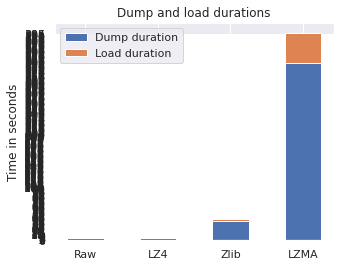

In [95]:
## memory read write comparison

import numpy as np
import matplotlib.pyplot as plt

N = 4
load_durations = (raw_load_duration, lz4_load_duration, zlib_load_duration,
                  lzma_load_duration)
dump_durations = (raw_dump_duration, lz4_dump_duration, zlib_dump_duration,
                  lzma_dump_duration)
file_sizes = (raw_file_size, lz4_file_size, zlib_file_size, lzma_file_size)
ind = np.arange(N)
width = 0.5

plt.figure(1, figsize=(5, 4))
p1 = plt.bar(ind, dump_durations, width)
p2 = plt.bar(ind, load_durations, width, bottom=dump_durations)
plt.ylabel('Time in seconds')
plt.title('Dump and load durations')
plt.xticks(ind, ('Raw', 'LZ4', 'Zlib', 'LZMA'))
plt.yticks(np.arange(0, lzma_load_duration + lzma_dump_duration))
plt.legend((p1[0], p2[0]), ('Dump duration', 'Load duration'))

([<matplotlib.axis.XTick at 0x7fb67df6f750>,
 [Text(0, 0, 'Raw'),
  Text(0, 0, 'LZ4'),
  Text(0, 0, 'Zlib'),
  Text(0, 0, 'LZMA')])

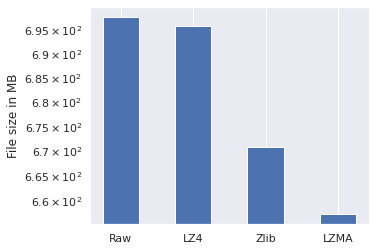

In [96]:
plt.figure(2, figsize=(5, 4))
plt.bar(ind, file_sizes, width, log=True)
plt.ylabel('File size in MB')
plt.xticks(ind, ('Raw', 'LZ4', 'Zlib', 'LZMA'))

In [97]:
# average loading time after compression of the preprocessed reviews

import time
from sklearn.externals import joblib
from tqdm import tqdm
import numpy as np

import pickle as pkl
time_gap=[]

for i in tqdm(range(20)):
    t1=time.time()
    X_tr=load('X_tr.joblib') #change to joblib.
    y_tr=load("y_tr.joblib") #change to joblib
    print(X_tr.shape,y_tr.shape)
    #tf_idf_final_avg_w2v= pd.DataFrame(tfidf_sent_vectors)
    #y_tr=pd.DataFrame(y_tr)
    t2=time.time()
    time_diff=t2-t1
    time_gap.append(time_diff)

import statistics 
average=statistics.mean(time_gap)
print(average)

ImportError: cannot import name 'joblib' from 'sklearn.externals' (/opt/conda/lib/python3.7/site-packages/sklearn/externals/__init__.py)

In [ ]:
data_1=False #english only reviews w2vec avg tf-idf #for 300
data_2=True #english and emoji only reviews tf-idf  #for 600

from sklearn.externals import joblib
import pandas as pd

X_tr_original = joblib.load('X_tr.joblib')
y_tr_original = joblib.load("y_tr.joblib")

X_tr_compressed=load('X_tr.joblib') 
y_tr_compressed=load("y_tr.joblib") 

print(np.array_equal(X_tr_original, X_tr_compressed))
print(np.array_equal(y_tr_original, y_tr_compressed))


# if we see two TRUE's that means the data is compressed and can be decompressed without any losses

In [ ]:
#sanity check that everything is alright
X_tr=X_tr_compressed
y_tr=y_tr_compressed

print(X_tr.shape,y_tr.shape)
print(type(X_tr),type(y_tr))

# visualization of the dataset using various techniques

Before we actually begin by visualizing the data let's recall what have we done so far

we have preprocessed our data where our X_tr.joblib contains 600 dimensional vectors where first 300 dimensions denote the word and the last 300 dimensions denote the emoji expression, for this vector representation we have used a pretrained word2vec model along side calculating the tf-idf score.

If we want to train our own word to vec (I assume with emoji's the better it would be 😊)
we can do so by changing our design choices but I prefer it with emoji's attached as they tell alot about the sentence


In [104]:
#run only once because of variable over write
from joblib import dump, load
import numpy as np
import pandas as pd

X_tr=load('X_tr.joblib') 
y_tr=load("y_tr.joblib") 

#let's see how the data looks like 
df = pd.DataFrame(X_tr)
df.describe() #clearly column 590 has no mean not scaled


EOFError: 

In [100]:
#so let's scale everything down to zero mean and 1 std
# x' =(x-U)/rho where rho is my std deviation
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized=scaler.fit_transform(df) #converted back to numpy
standardized_df =  pd.DataFrame(standardized)
X_tr=standardized_df
standardized_df.describe()

NameError: name 'df' is not defined

In [ ]:
#PCA implementation of an algorithm

from sklearn import decomposition
import copy
import seaborn as sns
import matplotlib.pyplot as plt

pca = decomposition.PCA()
labels=copy.deepcopy(y_tr)
labels = labels.reshape((-1,)) ###converts (n,1) to (n,)

pca.n_components = 3
pca_data = pca.fit_transform(X_tr)

# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)
print(type(pca_data),type(labels))
print(pca_data.shape,labels.shape)
pca_data = np.vstack((pca_data.T, labels)).T
# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "3rd_principal","labels"))

#randomly sample only 1 %age of the points from the original dataframe
small_df=pca_df.sample(frac=0.01, replace=False, random_state=1)

#see the size of the dataframe 
print(small_df.shape)

sns_plot=sns.FacetGrid(small_df, hue="labels", height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

#3d plot on pca
import plotly.express as px

fig = px.scatter_3d(small_df, x="1st_principal", y="2nd_principal", z="3rd_principal",
                    color="labels")
fig.show()

In [ ]:
sns_plot.savefig("output.png")

In [ ]:
small_df.describe()

In [ ]:
# PCA for dimensionality redcution (non-visualization)
pca.n_components = X_tr.shape[1]
pca_data = pca.fit_transform(X_tr)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_); ###returns a 1*600 matrix
#where each of the rwo denotes the percentage variance explained we divide it by total variance
cum_var_explained = np.cumsum(percentage_var_explained)
#do a cumlative sum
# Plot the PCA spectrum
pca_dim=plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()
pca_dim.savefig('line_plot.png') 

In [ ]:
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
X_tr=load('X_tr.joblib') 
labels=load("y_tr.joblib")
from sklearn.manifold import TSNE
model = TSNE(n_components=3, random_state=0 ,n_iter=2000,perplexity=40,n_jobs=-1) #random states for reproducable results
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000(n_iter)
labels=copy.deepcopy(y_tr)
labels = labels.reshape((-1,)) ###converts (n,1) to (n,)
tsne_data = np.vstack((X_tr.T, labels)).T


tsne_df = pd.DataFrame(data=tsne_data)
#randomly sample only 1 %age of the points from the original dataframe
tsne_df=tsne_df.sample(frac=0.01, replace=False, random_state=2)

labels= tsne_df.iloc[:,-1]
tsne_df = tsne_df.iloc[:, :-1]

print(labels.shape,tsne_df.shape)

tsne_data = model.fit_transform(tsne_df)

tsne_data = np.vstack((tsne_data.T, labels)).T

# creating a new data fram which help us in ploting the result data
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Dim_3","label"))
print(tsne_df.shape)

# Ploting the result of tsne
sns_plot=sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()
sns_plot.savefig("output_tsne.png")


import plotly.express as px

fig = px.scatter_3d(tsne_df, x='Dim_1', y='Dim_2', z='Dim_3',
                    color='label')
fig.show()

In [ ]:
#umap implementation 
from joblib import load
import umap
import numpy as np
import pandas as pd

X_tr=load('X_tr.joblib')
labels=load("y_tr.joblib")

labels = labels.reshape((-1,)) ###converts (n,1) to (n,)
umap_data = np.vstack((X_tr.T, labels)).T
umap_df = pd.DataFrame(data=umap_data)

#randomly sample only 1 %age of the points from the original dataframe
umap_df=umap_df.sample(frac=0.01, replace=False, random_state=2)

labels= umap_df.iloc[:,-1] ### select all the labels
umap_df = umap_df.iloc[:, :-1] ### select all the features corresponding
numpy_X_tr=umap_df.to_numpy()
print(labels.shape,umap_df.shape)


##### hyper parameter

#n_neighbour looks at the more global structure
#random_state= 42 means every time this will figure will be generated
#n_components =>>> how many dimensions you want to be reduced to
#min_dist ==>> less means more packing more means spread out


reducer = umap.UMAP(n_neighbors=15,random_state=42,metric='euclidean',min_dist=0.1,n_components=3)
reducer.fit(numpy_X_tr)

embedding = reducer.transform(numpy_X_tr)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
umap_data = np.vstack((embedding.T, labels)).T
umap_df = pd.DataFrame(data=umap_data, columns=("Dim_1", "Dim_2", "Dim_3","label"))

# Ploting the result of tsne
sns_plot=sns.FacetGrid(umap_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()
sns_plot.savefig("output_umap.png")

import plotly.express as px

fig = px.scatter_3d(umap_df, x='Dim_1', y='Dim_2', z='Dim_3',
                    color='label')
fig.show()

# Algorithm implementations using machine learning

In [105]:
#loading the data and standardizing it before actually implemnting algorithms
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
import numpy as np

X_tr_complete=load('X_tr.joblib')
X_tr_complete=X_tr_complete[:,:300]+X_tr_complete[:,300:]
print(X_tr_complete.shape)

y_tr_complete=load("y_tr.joblib")
shapes=y_tr_complete.shape
y_tr_complete = y_tr_complete.reshape((shapes[0],))#reshape y to y,

#standardization of the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(X_tr_complete))
X_tr_new=scaler.transform(X_tr_complete)
print("this is my new X_tr:{}".format(X_tr_new.shape))
print("are both the array's equal: ",np.array_equal(X_tr_complete,X_tr_new))

#train test split and random splitting
from sklearn.model_selection import train_test_split
# create training and testing data (80% train and 20% test)
X_tr, X_test, y_tr, y_test = train_test_split(X_tr_new, y_tr_complete, test_size=0.2,random_state=5)#test size here relates to second var i.e test

print("="*20+" train data (80%)"+"="*20)
print (X_tr.shape, y_tr.shape)
print("="*20+" test data (20%)"+"="*20)
print (X_test.shape, y_test.shape)

#since it is computational heavy to evaluate a ten fold evaluation for all the different hyperparameters such as
#1 k value 
#2 uniform or weighted 
#3 distance type

#we will now prioritize the bottom 2 first by a 80-20 split and evaluating their performance to see which parameter best performs
#then upon deciding a rough estimate of these parameters we will then try to implement a 10 fold evalution to find the main hyper parameter that is k



EOFError: 

# K nearest neighbour algorithm

1. we are now implementing the KNN algorithm to find the right k value, 
2. the weight association {wether we want weighted or uniform} 
3. and finally the distance metric to see the impact of the distances on knn

In [ ]:
#let's try to implement and fix our knn for the distance and the weight scheme used 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics #for confusion matrix
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from tqdm import tqdm
import time

start=time.time()
#simple classifier to see the runtime execution
clf_1=KNeighborsClassifier(algorithm="brute",n_jobs=-1)
print("fitting.........")
clf_1.fit(X_tr,y_tr)
print("getting predictions.........")
y_pred=clf_1.predict(X_test)
print("computing scores............")
_f1=f1_score(y_test,y_pred)
_acc=accuracy_score(y_test,y_pred)
print(_f1,_acc)
end=time.time()
print("total_execution time: {}".format(end-start))

#setting up the tuning parameters
tuned_parameters = {'metric': ["euclidean","manhattan","chebyshev","cosine"],"weights":["uniform","distance"]}

accuracy_list=[]
f1_list=[]


#run for all metrics
for _metric in tqdm(tuned_parameters["metric"]):
    #setting up the default k=5 and weights =uniform
    clf_1=KNeighborsClassifier(algorithm="brute",weights="uniform",metric=_metric,n_jobs=-1)
    clf_1.fit(X_tr,y_tr)
    y_pred=clf_1.predict(X_test)
    _f1=f1_score(y_test,y_pred)
    _acc=accuracy_score(y_test,y_pred)
    accuracy_list.append(_acc)
    f1_list.append(_f1)

print("accuracies:{} and f1_score:{}".format(accuracy_list,f1_list))
print("metrics tested :{}".format(tuned_parameters["metric"]))





fitting.........
getting predictions.........


  0%|          | 0/4 [00:00<?, ?it/s]

computing scores............
0.9201850915736671 0.8583123947317558
total_execution time: 1291.624932050705


 25%|██▌       | 1/4 [20:34<1:01:43, 1234.66s/it]

In [ ]:
print("accuracies:{} and f1_score:{}".format(accuracy_list,f1_list))
print("metrics tested :{}".format(tuned_parameters["metric"]))

In [5]:
#from previous results
accuracy_list=[0.8583123947317558, 0.8571803296794324, 0.8494905707264544, 0.8538117458652015] 
f1_list=[0.9201850915736671, 0.9195498837381113, 0.9156792376945209, 0.9161446660912121]

#['euclidean', 'manhattan', 'chebyshev', 'cosine']
tuned_parameters={"metric":['euclidean', 'manhattan', 'chebyshev', 'cosine']}

import time
start=time.time()
rows_to_filter=2000
#simple classifier to see the runtime execution
clf_1=KNeighborsClassifier(algorithm="brute",n_jobs=-1,metric="mahalanobis")
print("fitting.........")
clf_1.fit(X_tr[:rows_to_filter],y_tr[:rows_to_filter])
print("getting predictions.........")
y_pred=clf_1.predict(X_test[:rows_to_filter])
print("computing scores............")
_f1=f1_score(y_test[:rows_to_filter],y_pred)
_acc=accuracy_score(y_test[:rows_to_filter],y_pred)
print(_f1,_acc)
end=time.time()
print("total_execution time: {}".format(end-start))
#add the readings from mahalanobis
f1_list.append(_f1)
accuracy_list.append(_acc)
tuned_parameters["metric"].append("mahalanobis")


fitting.........
getting predictions.........


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1458: FutureWarning: from version 0.25, pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  "specified if Y is passed.", FutureWarning)


computing scores............
0.9108910891089108 0.838
total_execution time: 10.50234842300415


In [6]:
#equivalent to tanimoto
import time
start=time.time()
rows_to_filter=2000
#simple classifier to see the runtime execution
clf_1=KNeighborsClassifier(algorithm="brute",n_jobs=-1,metric="jaccard")
print("fitting.........")
clf_1.fit(X_tr[:rows_to_filter],y_tr[:rows_to_filter])
print("getting predictions.........")
y_pred=clf_1.predict(X_test[:rows_to_filter])
print("computing scores............")
_f1=f1_score(y_test[:rows_to_filter],y_pred)
_acc=accuracy_score(y_test[:rows_to_filter],y_pred)
print(_f1,_acc)
end=time.time()
print("total_execution time: {}".format(end-start))
#add the readings from mahalanobis
f1_list.append(_f1)
accuracy_list.append(_acc)
tuned_parameters["metric"].append("jaccard")

fitting.........
getting predictions.........
computing scores............
0.920086393088553 0.852
total_execution time: 0.203568696975708


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1761: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [14]:
#define hassanat distance formula 
def HasD(x, y):
    total = 0
    for xi, yi in zip(x, y):
        min_value = min(xi, yi)
        max_value = max(xi, yi)
        total += 1 # we sum the 1 in both cases
        if min_value >= 0:
            total -= (1 + min_value) / (1 + max_value )
        else:
            # min_value + abs(min_value) = 0, so we ignore that
            total -= 1 / (1 + max_value + abs(min_value))
    return total

rows_to_filter=100
#also run for hassanat
start=time.time()
#simple classifier to see the runtime execution
clf_1=KNeighborsClassifier(algorithm="brute",n_jobs=-1,metric=HasD)
print("fitting.........")
clf_1.fit(X_tr,y_tr)
print("getting predictions.........")
y_pred=clf_1.predict(X_test[:rows_to_filter])
print("computing scores............")
_f1=f1_score(y_test[:rows_to_filter],y_pred)
_acc=accuracy_score(y_test[:rows_to_filter],y_pred)
print(_f1,_acc)
end=time.time()
print("total_execution time: {}".format(end-start))
f1_list.append(_f1)
accuracy_list.append(_acc)
tuned_parameters["metric"].append("hassanat")
#once again print everything to see 

print("f1_scores:{} and accuracies :{}".format(accuracy_list,f1_list))
print("metrics tested :{}".format(tuned_parameters["metric"]))



fitting.........
getting predictions.........



KeyboardInterrupt



In [19]:
print(f1_list,accuracy_list,tuned_parameters_parameters["metric"])

[0.9201850915736671, 0.9195498837381113, 0.9156792376945209, 0.9161446660912121, 0.9108910891089108, 0.920086393088553, 1.0, 1.0, 1.0, 0.9473684210526316, 1.0] [0.8583123947317558, 0.8571803296794324, 0.8494905707264544, 0.8538117458652015, 0.838, 0.852, 1.0, 1.0, 1.0, 0.9, 1.0] ['euclidean', 'manhattan', 'chebyshev', 'cosine', 'mahalanobis', 'jaccard', 'hassanat', 'hassanat', 'hassanat', 'hassanat', 'hassanat']


In [30]:
accuracy_list=[0.8583123947317558, 0.8571803296794324, 0.8494905707264544, 0.8538117458652015,0.838,0.852,0.9] 
f1_list=[0.9201850915736671, 0.9195498837381113, 0.9156792376945209, 0.9161446660912121,0.9108,.92008,.9473]
#['euclidean', 'manhattan', 'chebyshev', 'cosine']
distances_used=['euclidean', 'manhattan', 'chebyshev', 'cosine',"mahalanobis","jaccard","hassanat"]

#distances_used=tuned_parameters["metric"]
print("f1_scores:{} and\naccuracies :{}".format(accuracy_list,f1_list))
print("metrics tested :{}".format(distances_used))





f1_scores:[0.8583123947317558, 0.8571803296794324, 0.8494905707264544, 0.8538117458652015, 0.838, 0.852, 0.9] and
accuracies :[0.9201850915736671, 0.9195498837381113, 0.9156792376945209, 0.9161446660912121, 0.9108, 0.92008, 0.9473]
metrics tested :['euclidean', 'manhattan', 'chebyshev', 'cosine', 'mahalanobis', 'jaccard', 'hassanat']


In [31]:
print("f1_scores:{} and accuracies :{}".format(accuracy_list,f1_list))
print("metrics tested :{}".format(distances_used))


f1_scores:[0.8583123947317558, 0.8571803296794324, 0.8494905707264544, 0.8538117458652015, 0.838, 0.852, 0.9] and accuracies :[0.9201850915736671, 0.9195498837381113, 0.9156792376945209, 0.9161446660912121, 0.9108, 0.92008, 0.9473]
metrics tested :['euclidean', 'manhattan', 'chebyshev', 'cosine', 'mahalanobis', 'jaccard', 'hassanat']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


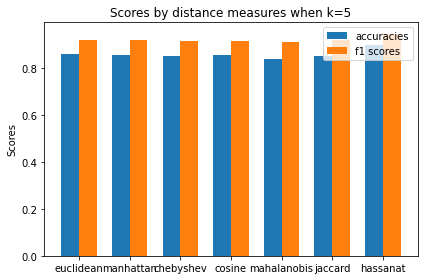

In [32]:
#performance comparisons of all distance metrics
#https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = distances_used
first_means = accuracy_list #accuracies
sec_means = f1_list #f1 lists 

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, first_means, width, label='accuracies')
rects2 = ax.bar(x + width/2, sec_means, width, label='f1 scores')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by distance measures when k=5')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)

fig.tight_layout()

plt.show()

In [34]:
#shows the most effective distance metric
print("maximum f1 score with {}".format(distances_used[f1_list.index(max(f1_list))]))
best_dist=distances_used[f1_list.index(max(f1_list))]
print(best_dist)

#due to time constraints for evaluating hassanat distance we will not prefer it 
best_dist="euclidean" #since this yeilds a the second highest scores #with much lower time
print(best_dist)


maximum f1 score with hassanat
hassanat
euclidean


In [ ]:
#now we try to tune the k value
#we know that a using distance is really good as it gives more weightage to the nearby points and less to the 
#far away points
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics #for confusion matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer, accuracy_score

#k nearest neigbour based approach
#since we are only taking here the odd numbers as it makes the voting easily
myList=range(1,100)
neighbors = list(filter(lambda x: x % 2 != 0, myList)) #neighbours is a list of numbers like 1,3,5....29

clf_1=KNeighborsClassifier(algorithm="brute",metric=best_dist,weights="distance")

tuned_parameters = {'n_neighbors': neighbors}

f1 = make_scorer(f1_score)

model_1 = GridSearchCV(clf_1, tuned_parameters, n_jobs=-1,scoring = f1, cv=3, verbose=10)
model_1.fit(X_tr, y_tr)
best_k=model_1.best_params_["n_neighbors"]


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


In [3]:
y_pred=model_1.predict(X_test)
acc=accuracy_score(y_test, y_pred)
_f1=f1_score(y_test,y_pred)

print("\nthis is my models accuracy :{}".format(acc))
print("\nthis is my models f1 :{}".format(_f1))

#plotting the confusion matrix from the data
import pandas as pd
confusion_matrix= metrics.confusion_matrix(y_test,y_pred)
(tn, fp, fn, tp)=(confusion_matrix[0][0],confusion_matrix[0][1],confusion_matrix[1][0],confusion_matrix[1][1])
print("KNN confusion matrix using brute:")
print("\ntn:%d\nfp:%d\nfn:%d\ntp:%d\n"%(tn, fp, fn, tp))




this is my models accuracy :0.8636275782091283

this is my models f1 :0.9245493431102965
KNN confusion matrix using brute:

tn:2035
fp:9313
fn:565
tp:60521



NameError: name 'sns' is not defined

The F1 score is the harmonic mean between the precision and recall hence we really don't need to calculate both of them 
my f1 score on test:  0.9245493431102965
my accuracy score on test:  0.8636275782091283


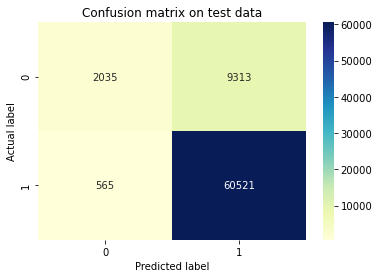

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
p = sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix on test data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("="*20)
print("The F1 score is the harmonic mean between the precision and recall hence we really don't need to calculate both of them ")
print("my f1 score on test: ",f1_score(y_test,y_pred))
print("my accuracy score on test: ",accuracy_score(y_test,y_pred))
print("="*20)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.408338,0.015378,1045.124627,6.881584,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.887287,0.886601,0.888946,0.887611,0.000984,29
1,1.485945,0.116402,1034.589727,6.752146,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.887287,0.886601,0.888946,0.887611,0.000984,29
2,1.393320,0.059736,1186.124835,13.452211,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.911392,0.911625,0.912931,0.911983,0.000677,28
3,1.409521,0.111331,1180.801396,3.560050,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.911578,0.911841,0.913157,0.912192,0.000691,27
4,1.553957,0.028554,1384.040277,11.445891,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.918510,0.918730,0.919354,0.918865,0.000357,26
5,1.446848,0.042127,1374.139129,13.027404,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.918701,0.918953,0.919590,0.919082,0.000374,25
6,1.445277,0.056875,1403.898808,11.894321,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.921242,0.920921,0.921947,0.921370,0.000429,24
7,1.598115,0.071857,1384.216495,14.670504,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.921428,0.921085,0.922110,0.921541,0.000426,23
8,1.707665,0.016158,1392.061171,4.728076,9,uniform,"{'n_neighbors': 9, 'weights': 'uniform'}",0.922346,0.922302,0.922947,0.922532,0.000295,22
9,1.550945,0.058084,1381.303622,5.907322,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",0.922494,0.922454,0.923185,0.922711,0.000336,21


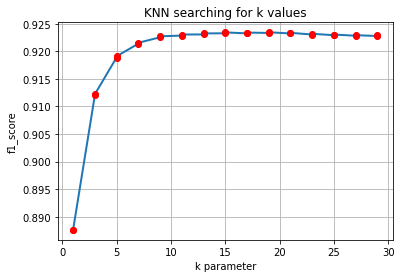

model tuned parameters:  {'n_neighbors': 19, 'weights': 'distance'}
model performance:  0.9234495920223001
model parameters:  <bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=KNeighborsClassifier(algorithm='brute',
                                            metric='euclidean',
                                            weights='distance'),
             n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score), verbose=10)>
model saved in the directory


In [3]:
#this block contains all the k values 
import pandas as pd
#plotting the hyper parameters
res=model_1.cv_results_
res = pd.DataFrame(data= res)
display(res)

alphas_list=list(res["param_n_neighbors"])
f1_scores=list(res["mean_test_score"])
#plotting graphs with matplot lib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(alphas_list,f1_scores, linewidth=2)
plt.plot(alphas_list,f1_scores, 'ro')
plt.axis('tight')
plt.grid()
plt.xlabel('k parameter')
plt.ylabel('f1_score')
plt.title("KNN searching for k values")
plt.show()

print("model tuned parameters: ", model_1.best_params_)
print("model performance: ", model_1.best_score_)
print("model parameters: ",model_1.get_params)

#let's consider saving our model

from joblib import dump, load
dump(model_1, 'GR_KNN_best_lz4.joblib', compress="lz4")
print("model saved in the directory")




In [2]:
#check loaded model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics #for confusion matrix
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from tqdm import tqdm
import time

#loading the data and standardizing it before actually implemnting algorithms
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
import numpy as np

X_tr_complete=load('X_tr.joblib')
X_tr_complete=X_tr_complete[:,:300]+X_tr_complete[:,300:]
print(X_tr_complete.shape)

y_tr_complete=load("y_tr.joblib")
shapes=y_tr_complete.shape
print(shapes)
y_tr_complete = y_tr_complete.reshape((shapes[0],))#reshape y to y,


#standardization of the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(X_tr_complete))
X_tr_new=scaler.transform(X_tr_complete)
print("this is my new X_tr:{}".format(X_tr_new.shape))
print("are both the array's equal: ",np.array_equal(X_tr_complete,X_tr_new))

#train test split and random splitting
from sklearn.model_selection import train_test_split
# create training and testing data (80% train and 20% test)
X_tr, X_test, y_tr, y_test = train_test_split(X_tr_new, y_tr_complete, test_size=0.2,random_state=5)#test size here relates to second var i.e test

print("="*20+" train data (80%)"+"="*20)
print (X_tr.shape, y_tr.shape)
print("="*20+" test data (20%)"+"="*20)
print (X_test.shape, y_test.shape)

model_1=load("GR_KNN_best_lz4.joblib") #denotes the model name

best_k=model_1.best_params_["n_neighbors"]
print(model_1.get_params)
y_pred=model_1.predict(X_test)
_f1=f1_score(y_test,y_pred)
_acc=accuracy_score(y_test,y_pred)
print(_f1,_acc)


(362168, 300)
(362168, 1)
StandardScaler()
this is my new X_tr:(362168, 300)
are both the array's equal:  False
==================== train data (80%)====================
(289734, 300) (289734,)
==================== test data (20%)====================
(72434, 300) (72434,)
<bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=KNeighborsClassifier(algorithm='brute',
                                            metric='euclidean',
                                            weights='distance'),
             n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score), verbose=10)>
0.9245493431102965 0.8636275782091283


(362168, 300)
y_tr------ (362168, 1)
MinMaxScaler()
this is my new X_tr:(362168, 300)
are both the array's equal:  False
==================== train data (80%)====================
(289734, 300) (289734,)
==================== test data (20%)====================
(72434, 300) (72434,)
Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  99 out of 147 | elapsed:   14.2s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done 114 out of 147 | elapsed:   14.4s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done 129 out of 147 | elapsed:   15.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done 144 out of 147 | elapsed:   15.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:   15.6s finished


0.7836025641184433
{'alpha': 2.3000000000000003}

this is the hyper parameter optimized alpha value: 2.3000000000000003

this is my models accuracy :0.686694093933788
CNB confusion matrix using tuned alphas and class priors:

tn:8147
fp:3201
fn:19493
tp:41593

The F1 score is the harmonic mean between the precision and recall hence we really don't need to
calculate both of them seperately 
f1: 0.7856630147336608
acc: 0.686694093933788
ComplementNB(alpha=2.3000000000000003, class_prior=[0.1568, 0.8432])


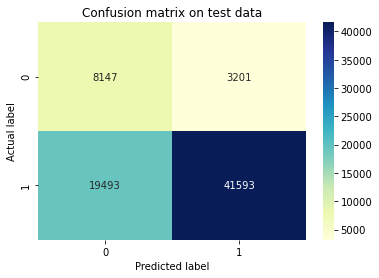

In [14]:
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics #for confusion matrix
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
import pandas as pd

X_tr_complete=load('X_tr.joblib')
X_tr_complete=X_tr_complete[:,:300]+X_tr_complete[:,300:]
print(X_tr_complete.shape)

y_tr_complete=load("y_tr.joblib")
shapes=y_tr_complete.shape
print("y_tr------",shapes)
y_tr_complete = y_tr_complete.reshape((shapes[0],))#reshape y to y,


#standardization of the dataset
#we use the min max scaling as this particualr naive bayes does not work on neagtive vector values
scaler = MinMaxScaler() #scaling is now min max
print(scaler.fit(X_tr_complete))

X_tr_new=scaler.transform(X_tr_complete)
print("this is my new X_tr:{}".format(X_tr_new.shape))
print("are both the array's equal: ",np.array_equal(X_tr_complete,X_tr_new))


#from train test split and random splitting
from sklearn.model_selection import train_test_split

# create training and testing data (80% train and 20% test)
X_tr, X_test, y_tr, y_test = train_test_split(X_tr_new, y_tr_complete, test_size=0.2,random_state=5)#test size here relates to second var i.e test

print("="*20+" train data (80%)"+"="*20)
print (X_tr.shape, y_tr.shape)
print("="*20+" test data (20%)"+"="*20)
print (X_test.shape, y_test.shape)

#naive bayes approach 
alphas=[x * 0.1 for x in range(1, 50)]

def assign_class_priors():
    final=[]
    for i in range(1,100):
        final.append((i*0.1,100-i*0.1))
    return final

class_priors=assign_class_priors() #this makes the last of class priors
class_priors=[.1568,1-0.1568] 

clf_2=ComplementNB(class_prior=class_priors)

tuned_parameters = {'alpha': alphas}

f1 = make_scorer(f1_score)

model_2 = GridSearchCV(clf_2, tuned_parameters, scoring = "f1", cv=3,n_jobs=-1, verbose=10)
model_2.fit(X_tr, y_tr)


best_alpha=model_2.best_params_["alpha"]
print(model_2.best_score_)
print(model_2.best_params_)

print("\nthis is the hyper parameter optimized alpha value: {}".format(best_alpha))
y_pred=model_2.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print("\nthis is my models accuracy :{}".format(acc))

#plotting the confusion matrix from the data
confusion_matrix= metrics.confusion_matrix(y_test,y_pred)
(tn, fp, fn, tp)=(confusion_matrix[0][0],confusion_matrix[0][1],confusion_matrix[1][0],confusion_matrix[1][1])
print("CNB confusion matrix using tuned alphas and class priors:")
print("\ntn:%d\nfp:%d\nfn:%d\ntp:%d\n"%(tn, fp, fn, tp))

p = sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix on test data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("="*20)
print("The F1 score is the harmonic mean between the precision and recall hence we really don't need to\ncalculate both of them seperately ")
print("f1: {}".format(f1_score(y_test,y_pred)))
print("acc: {}".format(accuracy_score(y_test,y_pred)))
print("="*20)
print(model_2.best_estimator_)

{'alpha': 2.3000000000000003}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.726976,0.040637,0.256644,0.014297,0.1,{'alpha': 0.1},0.784835,0.781143,0.784799,0.783592,0.001732,31
1,1.721479,0.025961,0.258350,0.016342,0.2,{'alpha': 0.2},0.784835,0.781149,0.784799,0.783594,0.001729,25
2,1.694851,0.017658,0.264179,0.008598,0.3,{'alpha': 0.30000000000000004},0.784835,0.781140,0.784799,0.783591,0.001733,33
3,1.703700,0.038042,0.257707,0.014517,0.4,{'alpha': 0.4},0.784835,0.781140,0.784799,0.783591,0.001733,33
4,1.717247,0.040866,0.251256,0.017700,0.5,{'alpha': 0.5},0.784835,0.781131,0.784799,0.783588,0.001738,45
5,1.698924,0.031390,0.246930,0.018476,0.6,{'alpha': 0.6000000000000001},0.784835,0.781131,0.784799,0.783588,0.001738,45
6,1.679120,0.049901,0.243946,0.028440,0.7,{'alpha': 0.7000000000000001},0.784835,0.781131,0.784799,0.783588,0.001738,45
7,1.718733,0.011954,0.208682,0.007912,0.8,{'alpha': 0.8},0.784835,0.781131,0.784790,0.783586,0.001736,49
8,1.690582,0.010480,0.207732,0.008628,0.9,{'alpha': 0.9},0.784852,0.781131,0.784790,0.783591,0.001740,35
9,1.700033,0.020244,0.203432,0.026194,1,{'alpha': 1.0},0.784861,0.781131,0.784790,0.783594,0.001742,26


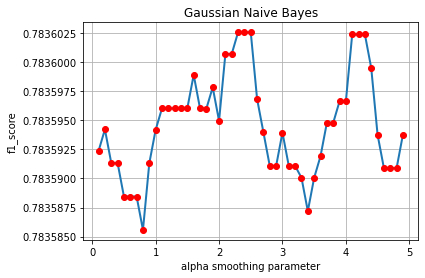

In [5]:
#plotting the hyper parameters

print(model_2.best_params_)
res=model_2.cv_results_
res = pd.DataFrame(data= res)
display(res)

alphas_list=list(res["param_alpha"])
f1_scores=list(res["mean_test_score"])
#plotting graphs with matplot lib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(alphas_list,f1_scores, linewidth=2)
plt.plot(alphas_list,f1_scores, 'ro')
plt.axis('tight')
plt.grid()
plt.xlabel('alpha smoothing parameter')
plt.ylabel('f1_score')
plt.title("Gaussian Naive Bayes")
plt.show()



In [ ]:
#logistic regression using optuna 

from sklearn import metrics #for confusion matrix
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import pandas as pd

X_tr_complete=load('X_tr.joblib')
X_tr_complete=X_tr_complete[:,:300]+X_tr_complete[:,300:]
print(X_tr_complete.shape)

y_tr_complete=load("y_tr.joblib")
shapes=y_tr_complete.shape
print("y_tr------",shapes)
y_tr_complete = y_tr_complete.reshape((shapes[0],))#reshape y to y,


#standardization of the dataset
#we use the min max scaling as this particualr naive bayes does not work on neagtive vector values
scaler = StandardScaler() #scaling is now min max
print(scaler.fit(X_tr_complete))

X_tr_new=scaler.transform(X_tr_complete)
print("this is my new X_tr:{}".format(X_tr_new.shape))
print("are both the array's equal: ",np.array_equal(X_tr_complete,X_tr_new))


#from train test split and random splitting
from sklearn.model_selection import train_test_split

# create training and testing data (80% train and 20% test)
X_tr, X_test, y_tr, y_test = train_test_split(X_tr_new, y_tr_complete, test_size=0.2,random_state=5)#test size here relates to second var i.e test

print("="*20+" train data (80%)"+"="*20)
print (X_tr.shape, y_tr.shape)
print("="*20+" test data (20%)"+"="*20)
print (X_test.shape, y_test.shape)



from sklearn.linear_model import LogisticRegression
from sklearn import metrics #for confusion matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer, accuracy_score


#hyper parameter tuning using bayesian search

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer, accuracy_score

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    
    #1- load the data
    global X_tr,y_tr
    X,y=X_tr,y_tr

    #define the search parameters and search space
    C_s=trial.suggest_loguniform('C', 1e-10, 1e10)
    penalties=trial.suggest_categorical('penalty', ['l1', 'l2',"elasticnet"])
    l1_ratios=trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    
    #init the classifier
    clf=LogisticRegression(C=C_s,penalty=penalties,l1_ratio=l1_ratios,random_state=0,solver="saga",n_jobs=-1)
    
    #define the scoring metric
    f1 = make_scorer(f1_score , average='macro')
    
    #get the k fold results
    score = cross_val_score(clf, X, y, n_jobs=-1, cv=3,scoring=f1)
    accuracy = score.mean() #this is mean f1 score
    return accuracy

study = optuna.create_study(direction="maximize",study_name='logistic_regression', storage='sqlite:///example.db', load_if_exists=True)
study.optimize(objective, n_trials=50,show_progress_bar=True,n_jobs=-1)



(362168, 300)
y_tr------ (362168, 1)
StandardScaler()
this is my new X_tr:(362168, 300)
are both the array's equal:  False
==================== train data (80%)====================
(289734, 300) (289734,)
==================== test data (20%)====================
(72434, 300) (72434,)


[I 2020-07-22 12:08:06,704] Using an existing study with name 'logistic_regression' instead of creating a new one.
/opt/conda/lib/python3.7/site-packages/optuna/study.py:344: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn(msg)
[W 2020-07-22 12:08:06,718] Progress bar only supports serial execution (`n_jobs=1`).
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/opt/conda/lib/py

In [ ]:
import optuna
study = optuna.create_study(direction="maximize",study_name='logistic_regression', storage='sqlite:///lr.db', load_if_exists=True)
df = study.trials_dataframe()
display(df)
print(study.best_params)
print(study.best_value)

optuna.visualization.plot_optimization_history(study)

(362168, 300)
y_tr------ (362168, 1)
StandardScaler()
this is my new X_tr:(362168, 300)
are both the array's equal:  False
==================== train data (80%)====================
(289734, 300) (289734,)
==================== test data (20%)====================
(72434, 300) (72434,)
<bound method BaseEstimator.get_params of LogisticRegression(C=43.7247427512106, multi_class='warn', penalty='l1',
                   solver='warn')>

this is my models accuracy :0.8840599718364304
CNB confusion matrix using tuned alphas and class priors:

tn:4814
fp:6534
fn:1864
tp:59222



/opt/conda/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.21.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


The F1 score is the harmonic mean between the precision and recall hence we really don't need to
calculate both of them seperately 
f1: 0.9337916463001213
acc: 0.8840599718364304


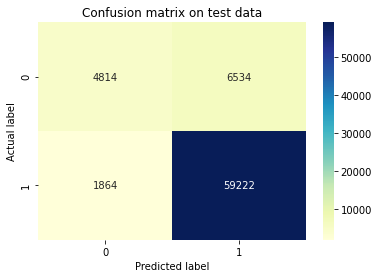

In [2]:
#load logistic regression model
from sklearn import metrics #for confusion matrix
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import pandas as pd

X_tr_complete=load('X_tr.joblib')
X_tr_complete=X_tr_complete[:,:300]+X_tr_complete[:,300:]
print(X_tr_complete.shape)

y_tr_complete=load("y_tr.joblib")
shapes=y_tr_complete.shape
print("y_tr------",shapes)
y_tr_complete = y_tr_complete.reshape((shapes[0],))#reshape y to y,


#standardization of the dataset
#we use the min max scaling as this particualr naive bayes does not work on neagtive vector values
scaler = StandardScaler() #scaling is now min max
print(scaler.fit(X_tr_complete))

X_tr_new=scaler.transform(X_tr_complete)
print("this is my new X_tr:{}".format(X_tr_new.shape))
print("are both the array's equal: ",np.array_equal(X_tr_complete,X_tr_new))


#from train test split and random splitting
from sklearn.model_selection import train_test_split

# create training and testing data (80% train and 20% test)
X_tr, X_test, y_tr, y_test = train_test_split(X_tr_new, y_tr_complete, test_size=0.2,random_state=5)#test size here relates to second var i.e test

print("="*20+" train data (80%)"+"="*20)
print (X_tr.shape, y_tr.shape)
print("="*20+" test data (20%)"+"="*20)
print (X_test.shape, y_test.shape)



from sklearn.linear_model import LogisticRegression
from sklearn import metrics #for confusion matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer, accuracy_score

model_1=load("LR.joblib")
print(model_1.get_params)

y_pred=model_1.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print("\nthis is my models accuracy :{}".format(acc))

#plotting the confusion matrix from the data
confusion_matrix= metrics.confusion_matrix(y_test,y_pred)
(tn, fp, fn, tp)=(confusion_matrix[0][0],confusion_matrix[0][1],confusion_matrix[1][0],confusion_matrix[1][1])
print("CNB confusion matrix using tuned alphas and class priors:")
print("\ntn:%d\nfp:%d\nfn:%d\ntp:%d\n"%(tn, fp, fn, tp))

p = sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix on test data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("="*20)
print("The F1 score is the harmonic mean between the precision and recall hence we really don't need to\ncalculate both of them seperately ")
print("f1: {}".format(f1_score(y_test,y_pred)))
print("acc: {}".format(accuracy_score(y_test,y_pred)))
print("="*20)

In [ ]:
from sklearn import metrics #for confusion matrix
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import pandas as pd

X_tr_complete=load('X_tr.joblib')
X_tr_complete=X_tr_complete[:,:300]+X_tr_complete[:,300:]
print(X_tr_complete.shape)

y_tr_complete=load("y_tr.joblib")
shapes=y_tr_complete.shape
print("y_tr------",shapes)
y_tr_complete = y_tr_complete.reshape((shapes[0],))#reshape y to y,


#standardization of the dataset
#we use the min max scaling as this particualr naive bayes does not work on neagtive vector values
scaler = StandardScaler() #scaling is now min max
print(scaler.fit(X_tr_complete))

X_tr_new=scaler.transform(X_tr_complete)
print("this is my new X_tr:{}".format(X_tr_new.shape))
print("are both the array's equal: ",np.array_equal(X_tr_complete,X_tr_new))


#from train test split and random splitting
from sklearn.model_selection import train_test_split

# create training and testing data (80% train and 20% test)

X_tr, X_test, y_tr, y_test = train_test_split(X_tr_new, y_tr_complete, test_size=0.2,random_state=5)#test size here relates to second var i.e test

print("="*20+" train data (80%)"+"="*20)
print (X_tr.shape, y_tr.shape)
print("="*20+" test data (20%)"+"="*20)
print (X_test.shape, y_test.shape)
#svm with gridsearch
from sklearn.svm import SVC
from sklearn import metrics #for confusion matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer, accuracy_score



import optuna
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer, accuracy_score

#init the classifier
clf=SVC(C=12.34,random_state=0)
clf.fit(X_tr,y_tr)

y_pred=clf.predict(X_test)
_f1=f1_score(y_test,y_pred)
_acc=accuracy_score(y_test,y_pred)

print(_f1,_acc)

(362168, 300)
y_tr------ (362168, 1)
StandardScaler()
this is my new X_tr:(362168, 300)
are both the array's equal:  False
==================== train data (80%)====================
(289734, 300) (289734,)
==================== test data (20%)====================
(72434, 300) (72434,)


In [1]:
#svm implementation

from sklearn import metrics #for confusion matrix
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import pandas as pd

X_tr_complete=load('X_tr.joblib')
X_tr_complete=X_tr_complete[:,:300]+X_tr_complete[:,300:]
print(X_tr_complete.shape)

y_tr_complete=load("y_tr.joblib")
shapes=y_tr_complete.shape
print("y_tr------",shapes)
y_tr_complete = y_tr_complete.reshape((shapes[0],))#reshape y to y,


#standardization of the dataset
#we use the min max scaling as this particualr naive bayes does not work on neagtive vector values
scaler = StandardScaler() #scaling is now min max
print(scaler.fit(X_tr_complete))

X_tr_new=scaler.transform(X_tr_complete)
print("this is my new X_tr:{}".format(X_tr_new.shape))
print("are both the array's equal: ",np.array_equal(X_tr_complete,X_tr_new))


#from train test split and random splitting
from sklearn.model_selection import train_test_split

# create training and testing data (80% train and 20% test)

X_tr, X_test, y_tr, y_test = train_test_split(X_tr_new, y_tr_complete, test_size=0.2,random_state=5)#test size here relates to second var i.e test

print("="*20+" train data (80%)"+"="*20)
print (X_tr.shape, y_tr.shape)
print("="*20+" test data (20%)"+"="*20)
print (X_test.shape, y_test.shape)
#svm with gridsearch
from sklearn.svm import SVC
from sklearn import metrics #for confusion matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer, accuracy_score



import optuna
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer, accuracy_score

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    
    #1- load the data
    global X_tr,y_tr
    X,y=X_tr,y_tr

    #define the search parameters and search space
    C_s=trial.suggest_loguniform('C', 1e-3, 1e3)
    kernels=trial.suggest_categorical('kernels',["linear", "poly", "rbf", "sigmoid"])
    
    #init the classifier
    clf=SVC(C=C_s,kernel=kernels,random_state=0)
    
    #define the scoring metric
    f1 = make_scorer(f1_score , average='macro')
    
    #get the k fold results
    score = cross_val_score(clf, X, y, n_jobs=-1, cv=3,scoring=f1)
    accuracy = score.mean() #this is mean f1 score
    print("="*20)
    print(accuracy)
    print("="*20)
    return accuracy

study = optuna.create_study(direction="maximize",study_name='logistic_regression', storage='sqlite:///svm.db', load_if_exists=True)
study.optimize(objective, n_trials=100,show_progress_bar=True,n_jobs=-1)

study = optuna.create_study(direction="maximize",study_name='logistic_regression', storage='sqlite:///svm.db', load_if_exists=True)
df = study.trials_dataframe()
display(df)
print(study.best_params)
print(study.best_value)

optuna.visualization.plot_optimization_history(study)


(362168, 300)
y_tr------ (362168, 1)
StandardScaler()
this is my new X_tr:(362168, 300)
are both the array's equal:  False
==================== train data (80%)====================
(289734, 300) (289734,)
==================== test data (20%)====================
(72434, 300) (72434,)


[I 2020-07-22 17:06:18,332] Using an existing study with name 'logistic_regression' instead of creating a new one.
/opt/conda/lib/python3.7/site-packages/optuna/study.py:344: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn(msg)
[W 2020-07-22 17:06:18,347] Progress bar only supports serial execution (`n_jobs=1`).


KeyboardInterrupt: 

class imabalnce techniques to generate synthetic samples

(362168, 300)
y_tr------ (362168, 1)
StandardScaler()
this is my new X_tr:(362168, 300)
are both the array's equal:  False
==================== train data (80%)====================
(289734, 300) (289734,)
==================== test data (20%)====================
(72434, 300) (72434,)
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   25.5s remaining:   51.0s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   25.7s remaining:   25.7s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   37.2s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   37.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   37.5s finished


0.5522657119603075
3

this is the hyper parameter optimized max depth value: 3

this is my models accuracy :0.6487423033382114
naive bayes confusion matrix using tuned alphas:

tn:7161
fp:4187
fn:21256
tp:39830

The F1 score is the harmonic mean between the precision and recall... 
my f1 score on test:  0.5590445776111423
my accuracy score on test:  0.6487423033382114


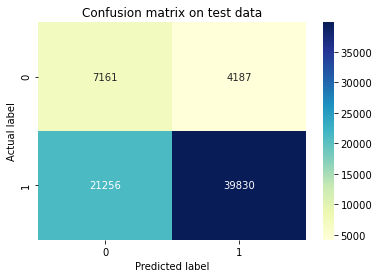

In [7]:
#decision tree based implementation
from sklearn import metrics #for confusion matrix
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import pandas as pd

X_tr_complete=load('X_tr.joblib')
X_tr_complete=X_tr_complete[:,:300]+X_tr_complete[:,300:]
print(X_tr_complete.shape)

y_tr_complete=load("y_tr.joblib")
shapes=y_tr_complete.shape
print("y_tr------",shapes)
y_tr_complete = y_tr_complete.reshape((shapes[0],))#reshape y to y,


#standardization of the dataset
#we use the min max scaling as this particualr naive bayes does not work on neagtive vector values
scaler = StandardScaler() #scaling is now min max
print(scaler.fit(X_tr_complete))

X_tr_new=scaler.transform(X_tr_complete)
print("this is my new X_tr:{}".format(X_tr_new.shape))
print("are both the array's equal: ",np.array_equal(X_tr_complete,X_tr_new))


#from train test split and random splitting
from sklearn.model_selection import train_test_split

# create training and testing data (80% train and 20% test)

X_tr, X_test, y_tr, y_test = train_test_split(X_tr_new, y_tr_complete, test_size=0.2,random_state=5)#test size here relates to second var i.e test

print("="*20+" train data (80%)"+"="*20)
print (X_tr.shape, y_tr.shape)
print("="*20+" test data (20%)"+"="*20)
print (X_test.shape, y_test.shape)

#Decision Trees with gridsearch
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics #for confusion matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer, accuracy_score


clf = DecisionTreeClassifier(max_features=300,class_weight="balanced",random_state=1) #takes into prior probabilites into account

max_depths=[x for x in range(2,4)]

tuned_parameters = {'max_depth': max_depths}

f1 = make_scorer(f1_score , average='macro')

model_1 = GridSearchCV(clf, tuned_parameters, scoring = f1, cv=3,n_jobs=-1, verbose=10)
model_1.fit(X_tr, y_tr)

best_depth=model_1.best_params_["max_depth"]
print(model_1.best_score_)
print(best_depth)
print("\nthis is the hyper parameter optimized max depth value: {}".format(best_depth))
y_pred=model_1.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print("\nthis is my models accuracy :{}".format(acc))

#plotting the confusion matrix from the data
confusion_matrix= metrics.confusion_matrix(y_test,y_pred)
(tn, fp, fn, tp)=(confusion_matrix[0][0],confusion_matrix[0][1],confusion_matrix[1][0],confusion_matrix[1][1])
print("naive bayes confusion matrix using tuned alphas:")
print("\ntn:%d\nfp:%d\nfn:%d\ntp:%d\n"%(tn, fp, fn, tp))

p = sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix on test data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("="*20)
print("The F1 score is the harmonic mean between the precision and recall... ")
print("my f1 score on test: ",f1_score(y_test,y_pred ,average="macro"))
print("my accuracy score on test: ",accuracy_score(y_test,y_pred))
print("="*20)

this is the decision tree with the accuracy of :64.87423033382113%


[Text(167.4, 190.26, 'X[64] <= -0.366\ngini = 0.5\nsamples = 289734\nvalue = [144867.0, 144867.0]'),
 Text(83.7, 135.9, 'X[189] <= -0.309\ngini = 0.474\nsamples = 100205\nvalue = [72919.481, 45856.314]'),
 Text(41.85, 81.53999999999999, 'X[129] <= -0.178\ngini = 0.499\nsamples = 33323\nvalue = [15452.607, 16886.472]'),
 Text(20.925, 27.180000000000007, 'gini = 0.483\nsamples = 12907\nvalue = [8718.98, 6031.9]'),
 Text(62.775000000000006, 27.180000000000007, 'gini = 0.473\nsamples = 20416\nvalue = [6733.627, 10854.573]'),
 Text(125.55000000000001, 81.53999999999999, 'X[119] <= 0.202\ngini = 0.446\nsamples = 66882\nvalue = [57466.874, 28969.842]'),
 Text(104.625, 27.180000000000007, 'gini = 0.488\nsamples = 32173\nvalue = [20749.005, 15218.819]'),
 Text(146.475, 27.180000000000007, 'gini = 0.396\nsamples = 34709\nvalue = [36717.868, 13751.023]'),
 Text(251.10000000000002, 135.9, 'X[129] <= -0.311\ngini = 0.487\nsamples = 189529\nvalue = [71947.519, 99010.686]'),
 Text(209.25, 81.53999999

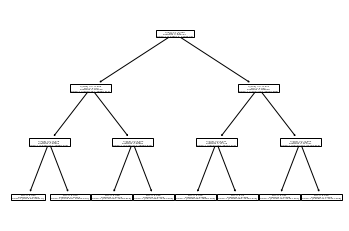

In [8]:
# we are limiting our depth uptil 10 max nodes because this reduces the interpretebility
best_tree=model_1.best_estimator_
from sklearn import tree
tree.export_graphviz(best_tree)
print("this is the decision tree with the accuracy of :{}%".format(acc*100))
tree.plot_tree(best_tree) 

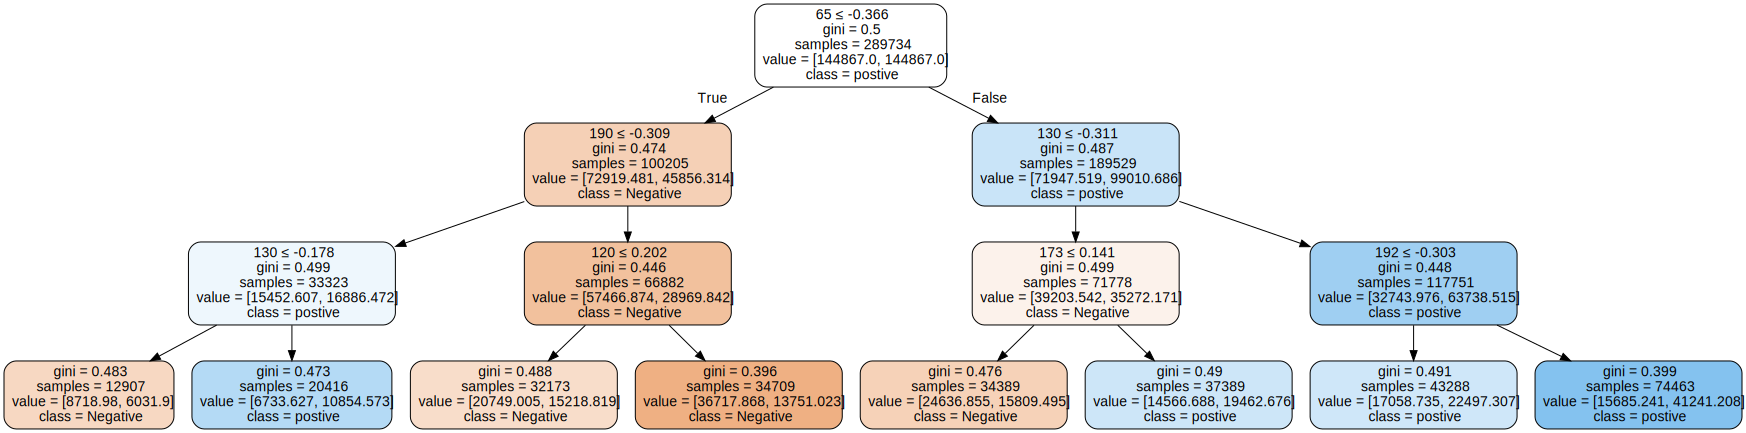

In [20]:
#refer-https://scikit-learn.org/stable/modules/tree.html
import graphviz 
from subprocess import check_call
mapping_dict={'Negative':0, 'postive':1}
tmp=list(mapping_dict)
data_feature_names=[str(x) for x in range(1,301)]

dot_data = tree.export_graphviz(best_tree, out_file=None, 
                     feature_names=data_feature_names,  
                     class_names=tmp,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
graph


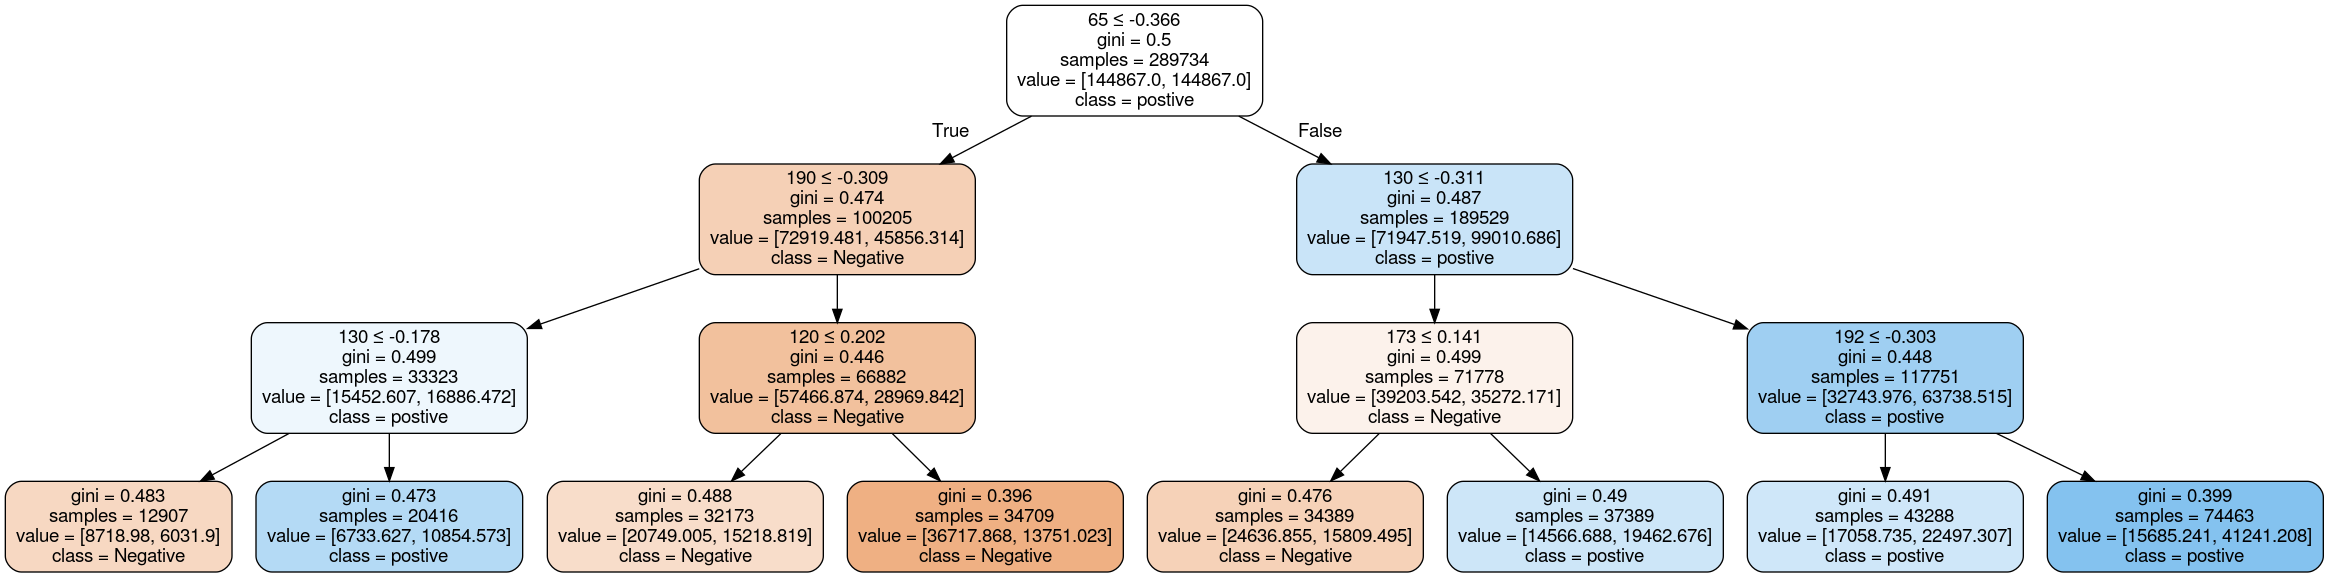

In [21]:
#source- https://www.datacamp.com/community/tutorials/decision-tree-classification-python
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(best_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=data_feature_names,  
                class_names=tmp,  )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('my_tree_3.png') ######turn this on if you want to save
Image(graph.create_png())



# this is running the ensembles random forest 

(362168, 300)
y_tr------ (362168, 1)
StandardScaler()
this is my new X_tr:(362168, 300)
are both the array's equal:  False
==================== train data (80%)====================
(289734, 300) (289734,)
==================== test data (20%)====================
(72434, 300) (72434,)
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done   4 out of  60 | elapsed: 17.7min remaining: 247.2min
[Parallel(n_jobs=-1)]: Done  11 out of  60 | elapsed: 19.9min remaining: 88.8min
[Parallel(n_jobs=-1)]: Done  18 out of  60 | elapsed: 23.2min remaining: 54.1min
[Parallel(n_jobs=-1)]: Done  25 out of  60 | elapsed: 25.5min remaining: 35.8min
[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed: 28.0min remaining: 24.5min
[Parallel(n_jobs=-1)]: Done  39 out of  60 | elapsed: 38.5min remaining: 20.7min
[Parallel(n_jobs=-1)]: Done  46 out of  60 | elapsed: 42.6min remaining: 13.0min
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed: 46.4min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 50.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 50.2min finished


0.5318747887851911
150

this is the hyper parameter optimized number of trees value: 150

this is my models accuracy :0.8531214622967115
naive bayes confusion matrix using tuned alphas:

tn:928
fp:10420
fn:219
tp:60867

The F1 score is the harmonic mean between the precision and recall... 
my f1 score on test:  0.5340840204695568
my accuracy score on test:  0.8531214622967115


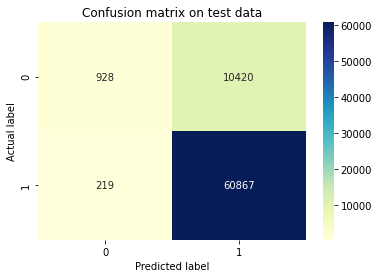

In [1]:
#Ensembling based on Random forest 
#random forest = bagging K large depth decision trees with Row sampling and column Sampling

from sklearn import metrics #for confusion matrix
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import pandas as pd

X_tr_complete=load('X_tr.joblib')
X_tr_complete=X_tr_complete[:,:300]+X_tr_complete[:,300:]
print(X_tr_complete.shape)

y_tr_complete=load("y_tr.joblib")
shapes=y_tr_complete.shape
print("y_tr------",shapes)
y_tr_complete = y_tr_complete.reshape((shapes[0],))#reshape y to y,


#standardization of the dataset
#we use the min max scaling as this particualr naive bayes does not work on neagtive vector values
scaler = StandardScaler() #scaling is now min max
print(scaler.fit(X_tr_complete))

X_tr_new=scaler.transform(X_tr_complete)
print("this is my new X_tr:{}".format(X_tr_new.shape))
print("are both the array's equal: ",np.array_equal(X_tr_complete,X_tr_new))


#from train test split and random splitting
from sklearn.model_selection import train_test_split

# create training and testing data (80% train and 20% test)

X_tr, X_test, y_tr, y_test = train_test_split(X_tr_new, y_tr_complete, test_size=0.2,random_state=5)#test size here relates to second var i.e test

print("="*20+" train data (80%)"+"="*20)
print (X_tr.shape, y_tr.shape)
print("="*20+" test data (20%)"+"="*20)
print (X_test.shape, y_test.shape)
#svm with gridsearch
from sklearn.svm import SVC
from sklearn import metrics #for confusion matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer, accuracy_score



from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn import metrics #for confusion matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer, accuracy_score


#full rowSsampling and col sampling by rootn
clf = RandomForestClassifier(random_state=1) #takes into prior probabilites into account

n_estimators=[x for x in range(150,250,10)]

class_weigting_types=["balanced","balanced_subsample"]

tuned_parameters = {'n_estimators': n_estimators,"class_weight":class_weigting_types}

f1 = make_scorer(f1_score , average='macro')

model_1 = GridSearchCV(clf, tuned_parameters, scoring = f1, cv=3,n_jobs=-1, verbose=10)
model_1.fit(X_tr, y_tr)

best_estimator_counts=model_1.best_params_["n_estimators"]
best_weighing_scheme=model_1.best_params_["class_weight"]

print(model_1.best_score_)
print(best_estimator_counts)
print("\nthis is the hyper parameter optimized number of trees value: {}".format(best_estimator_counts))

y_pred=model_1.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print("\nthis is my models accuracy :{}".format(acc))

#plotting the confusion matrix from the data
confusion_matrix= metrics.confusion_matrix(y_test,y_pred)
(tn, fp, fn, tp)=(confusion_matrix[0][0],confusion_matrix[0][1],confusion_matrix[1][0],confusion_matrix[1][1])
print("naive bayes confusion matrix using tuned alphas:")
print("\ntn:%d\nfp:%d\nfn:%d\ntp:%d\n"%(tn, fp, fn, tp))

p = sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix on test data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("="*20)
print("The F1 score is the harmonic mean between the precision and recall... ")
print("my f1 score on test: ",f1_score(y_test,y_pred ,average="macro"))
print("my accuracy score on test: ",accuracy_score(y_test,y_pred))
print("="*20)

In [2]:
dump(model_1,"rf.joblib")

['rf.joblib']

In [1]:
# import XGBClassifier
from sklearn import metrics #for confusion matrix
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import pandas as pd

X_tr_complete=load('X_tr.joblib')
X_tr_complete=X_tr_complete[:,:300]+X_tr_complete[:,300:]
print(X_tr_complete.shape)

y_tr_complete=load("y_tr.joblib")
shapes=y_tr_complete.shape
print("y_tr------",shapes)
y_tr_complete = y_tr_complete.reshape((shapes[0],))#reshape y to y,


#standardization of the dataset
#we use the min max scaling as this particualr naive bayes does not work on neagtive vector values
scaler = StandardScaler() #scaling is now min max
print(scaler.fit(X_tr_complete))

X_tr_new=scaler.transform(X_tr_complete)
print("this is my new X_tr:{}".format(X_tr_new.shape))
print("are both the array's equal: ",np.array_equal(X_tr_complete,X_tr_new))


#from train test split and random splitting
from sklearn.model_selection import train_test_split

# create training and testing data (80% train and 20% test)

X_tr, X_test, y_tr, y_test = train_test_split(X_tr_new, y_tr_complete, test_size=0.2,random_state=5)#test size here relates to second var i.e test

print("="*20+" train data (80%)"+"="*20)
print (X_tr.shape, y_tr.shape)
print("="*20+" test data (20%)"+"="*20)
print (X_test.shape, y_test.shape)
from xgboost import XGBClassifier

# instantiate the classifier 
xgb_clf = XGBClassifier(n_jobs=-1,random_state=1)

# fit the classifier to the training data
xgb_clf.fit(X_tr, y_tr)



(362168, 300)
y_tr------ (362168, 1)
StandardScaler()
this is my new X_tr:(362168, 300)
are both the array's equal:  False
==================== train data (80%)====================
(289734, 300) (289734,)
==================== test data (20%)====================
(72434, 300) (72434,)


NameError: name 'model_1' is not defined


this is my models accuracy :0.8836872187094459
naive bayes confusion matrix using tuned alphas:

tn:4897
fp:6451
fn:1974
tp:59112

The F1 score is the harmonic mean between the precision and recall... 
my f1 score on test:  0.7355241159800006
my accuracy score on test:  0.8836872187094459


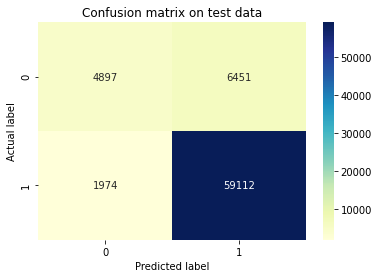

In [3]:
y_pred=xgb_clf.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print("\nthis is my models accuracy :{}".format(acc))

#plotting the confusion matrix from the data
confusion_matrix= metrics.confusion_matrix(y_test,y_pred)
(tn, fp, fn, tp)=(confusion_matrix[0][0],confusion_matrix[0][1],confusion_matrix[1][0],confusion_matrix[1][1])
print("naive bayes confusion matrix using tuned alphas:")
print("\ntn:%d\nfp:%d\nfn:%d\ntp:%d\n"%(tn, fp, fn, tp))

p = sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix on test data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("="*20)
print("The F1 score is the harmonic mean between the precision and recall... ")
print("my f1 score on test: ",f1_score(y_test,y_pred ,average="macro"))
print("my accuracy score on test: ",accuracy_score(y_test,y_pred))
print("="*20)

In [4]:
dump(xgb_clf,"xgboost.joblib")

['xgboost.joblib']


this is my models accuracy :0.8840737775078003
naive bayes confusion matrix using tuned alphas:

tn:4816
fp:6532
fn:1865
tp:59221

The F1 score is the harmonic mean between the precision and recall... 
my f1 score on test:  0.734024169372655
my accuracy score on test:  0.8840737775078003


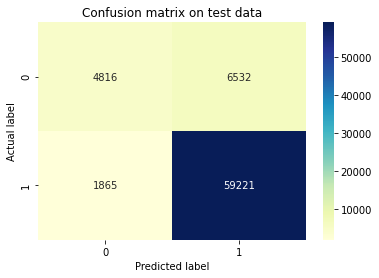

In [5]:
# import XGBClassifier
from xgboost import XGBClassifier

# instantiate the classifier 
xgb_clf = XGBClassifier(booster="gblinear",random_state=1,n_jobs=-1)

# fit the classifier to the training data
xgb_clf.fit(X_tr, y_tr)

y_pred=xgb_clf.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print("\nthis is my models accuracy :{}".format(acc))

#plotting the confusion matrix from the data
confusion_matrix= metrics.confusion_matrix(y_test,y_pred)
(tn, fp, fn, tp)=(confusion_matrix[0][0],confusion_matrix[0][1],confusion_matrix[1][0],confusion_matrix[1][1])
print("naive bayes confusion matrix using tuned alphas:")
print("\ntn:%d\nfp:%d\nfn:%d\ntp:%d\n"%(tn, fp, fn, tp))

p = sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix on test data')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("="*20)
print("The F1 score is the harmonic mean between the precision and recall... ")
print("my f1 score on test: ",f1_score(y_test,y_pred ,average="macro"))
print("my accuracy score on test: ",accuracy_score(y_test,y_pred))
print("="*20)

In [6]:
dump(xgb_clf,"xgboost_linear.joblib")

['xgboost_linear.joblib']

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_tr, y_tr)
print(X_resampled.shape,y_resampled.shape)

from joblib import dump

dump(X_resampled,"X_tr_ROS.joblib")
dump(y_resampled,"y_tr_ROS.joblib")

In [10]:
from imblearn.over_sampling import SMOTE, ADASYN
ros = SMOTE(random_state=0,n_jobs=-1)
X_resampled, y_resampled = ros.fit_resample(X_tr, y_tr)
print(X_resampled.shape,y_resampled.shape)

(488550, 300) (488550,)


In [11]:
dump(X_resampled,"X_tr_smote.joblib")
dump(y_resampled,"y_tr_smote.joblib")

['y_tr_smote.joblib']

In [12]:
from imblearn.over_sampling import SMOTE, ADASYN
ros = ADASYN(random_state=0,n_jobs=-1)
X_resampled, y_resampled = ros.fit_resample(X_tr, y_tr)
print(X_resampled.shape,y_resampled.shape)

dump(X_resampled,"X_tr_adasyn.joblib")
dump(y_resampled,"y_tr_adasyn.joblib")

(491564, 300) (491564,)


['y_tr_adasyn.joblib']

In [ ]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0,n_jobs=-1)
X_resampled, y_resampled = smote_tomek.fit_resample(X_tr, y_tr)
print(X_resampled.shape,y_resampled.shape)

dump(X_resampled,"X_tr_SMOTETomek.joblib")
dump(y_resampled,"y_tr_SMOTETomek.joblib")

In [ ]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0,n_jobs=-1)
X_resampled, y_resampled = smote_enn.fit_resample(X_tr, y_tr)
print(X_resampled.shape,y_resampled.shape)

dump(X_resampled,"X_tr_SMOTEEEN.joblib")
dump(y_resampled,"y_tr_SMOTEEEN.joblib")

(362168, 300)
y_tr------ (362168, 1)
(362168, 300) (362168,)
MinMaxScaler()
this is my new X_tr:(362168, 300)
are both the array's equal:  False
==================== train data (80%)====================
(289734, 300) (289734,)
==================== test data (20%)====================
(72434, 300) (72434,)
(491564, 300) (491564,)
0.0    247289
1.0    244275
Name: Column1, dtype: int64
Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  99 out of 147 | elapsed:   15.6s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done 114 out of 147 | elapsed:   15.8s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done 129 out of 147 | elapsed:   17.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done 144 out of 147 | elapsed:   17.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 147 out of 147 | elapsed:   17.8s finished


0.6916327060732969
{'alpha': 3.7}

this is the hyper parameter optimized alpha value: 3.7

this is my models accuracy :0.6879227986857


NameError: name 'y_t' is not defined

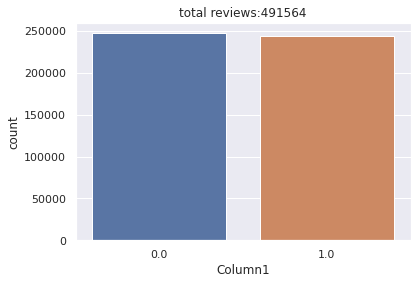